In [1]:
# set working directory
import os
os.chdir("C:/Users/yvjennig/PycharmProjects/phd_repos/clustering/")
print(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor

C:\Users\yvjennig\PycharmProjects\phd_repos\clustering


# Evaluate hyperparameter tuning

In [2]:
# maps for plotting
map_imputer_label = {"mean_imputer": "Mean", "knn_imputer": "KNN", "gain_imputer": "GAIN", "missforest_imputer": "MissForest"}
map_param_label = {"P_TEMPERATURE": "Temperature", "P_SALINITY": "Salinity", "P_OXYGEN": "Oxygen", "P_PHOSPHATE": "Phosphate", "P_NITRATE": "Nitrate", "P_SILICATE": "Silicate"}
map_param_unit = {"P_TEMPERATURE": "°C", "P_SALINITY": "psu", "P_OXYGEN": "µmol/kg", "P_PHOSPHATE": "µmol/kg", "P_NITRATE": "µmol/kg", "P_SILICATE": "µmol/kg"}

## Preprocessing

First, we need to combine config files of all experiments as well as result files from all experiments. 

In [4]:
scaler = "minmaxscaler"
dir_path = f"C:/Users/yvjennig/PycharmProjects/phd_repos/clustering/output/imputation/{scaler}/"

paths = []
for path, subdirs, files in os.walk(dir_path):
    for name in files:
        temp_path = os.path.join(path, name)
        paths.append(temp_path)
        
config_paths = [x for x in paths if "config.csv" in x]
res_file_paths = [x for x in paths if x not in config_paths]

In [5]:
# create dir for training results
output_path = f"output/imputation/{scaler}/train_results/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [6]:
# merge config files
df_config = pd.concat((pd.read_csv(f) for f in config_paths), ignore_index=True)

# add a column indicating the experiment number
df_config["experiment"] = 0

if "tuning_filename" in df_config.columns:
    df_config_exp0_idx = df_config[(df_config["tuning_filename"].str.contains("0.csv", na=False)) | (df_config["tuning_filenames"].str.contains("0.csv", na=False))].index
    df_config_exp1_idx = df_config[(df_config["tuning_filename"].str.contains("1.csv", na=False)) | (df_config["tuning_filenames"].str.contains("1.csv", na=False))].index
else:
    df_config_exp0_idx = df_config[df_config["tuning_filenames"].str.contains("0.csv", na=False)].index
    df_config_exp1_idx = df_config[df_config["tuning_filenames"].str.contains("1.csv", na=False)].index

df_config.loc[df_config_exp0_idx, "experiment"] = 0
df_config.loc[df_config_exp1_idx, "experiment"] = 1

# save config
df_config.to_csv(output_path + "config.csv", index=False)

In [7]:
# combine all output files into one
tuning_filepaths = []
tuning_dfs = []
for index, row in df_config.iterrows():
    if "tuning_filename" in df_config.columns:
        tuning_filename = row["tuning_filename"] if str(row["tuning_filename"]) != "nan" else row["tuning_filenames"].replace("[", "").replace("]", "").replace("'", "")
    else:
        tuning_filename = row["tuning_filenames"].replace("[", "").replace("]", "").replace("'", "")
    tuning_filename = f"output/imputation/{scaler}/" + tuning_filename.lstrip("output/imputation/")
    tuning_filepaths.append(tuning_filename)
    temp_df = pd.read_csv(tuning_filename)
    
    # read df
    temp_df["timestamp"] = tuning_filename.split("/")[3]
    temp_df["experiment"] = tuning_filename.rsplit(".csv")[0][-1]
    tuning_dfs.append(temp_df)
    
# put all results into one df and save it
df_tuning_results = pd.concat(tuning_dfs, axis=0)
df_tuning_results.to_csv(output_path + "tuning_results.csv", index=False)

In [8]:
df_config["imputer_name"].unique()

array(['mean_imputer', 'knn_imputer', 'missforest_imputer',
       'gain_imputer', 'iterative_rf_imputer', 'iterative_ridge_imputer'],
      dtype=object)

In [9]:
df_config

,timestamp,host,output_path,overall_runtime,parameters,imputer_name,tuning_filenames,tuning_iterations,tuning_missing_value_proportions,tuning_hyperparameters,experiment
0,1679483819,aqua,output/imputation/1679483819/,20.692001,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",mean_imputer,['output/imputation/1679483819/1679483819_hype...,50,"[0.004239443784975411, 1, 10, 20, 30, 40, 50, ...","{'missing_values': [nan], 'strategy': ['mean']}",0
1,1679484191,aqua,output/imputation/1679484191/,71.768851,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",mean_imputer,['output/imputation/1679484191/1679484191_hype...,50,"[0.004239443784975411, 1, 10, 20, 30, 40, 50, ...","{'missing_values': [nan], 'strategy': ['mean']}",1
2,1679484434,aqua,output/imputation/1679484434/,159953.403914,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",knn_imputer,['output/imputation/1679484434/1679484434_hype...,50,"[0.004239443784975411, 1, 10, 20, 30, 40, 50, ...","{'n_neighbors': [1, 5, 10, 20, 30, 40, 50], 'w...",1
3,1679656925,aqua,output/imputation/1679656925/,76217.596479,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",knn_imputer,['output/imputation/1679656925/1679656925_hype...,50,"[0.004239443784975411, 1, 10, 20, 30, 40, 50, ...","{'n_neighbors': [1, 5, 10, 20, 30, 40, 50], 'w...",0
4,1679728730,mare,output/imputation/1679728730/,50292.336637,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",missforest_imputer,['output/imputation/1679728730/1679728730_hype...,50,"[0.004239443784975411, 1, 10, 20, 30, 40, 50, ...","{'n_estimators': [10, 50, 100, 200], 'max_iter...",1
...,...,...,...,...,...,...,...,...,...,...,...
91,1681073987,aqua,output/imputation/1681073987/,52303.480909,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",gain_imputer,['output/imputation/1681073987/1681073987_hype...,10,"[0.004239443784975411, 1, 10, 20, 30, 40, 50, ...","{'alpha': [1, 10, 20, 30, 40, 50, 60, 70, 80, ...",0
92,1681193664,aqua,output/imputation/1681193664/,52336.633239,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",gain_imputer,['output/imputation/1681193664/1681193664_hype...,10,"[0.004239443784975411, 1, 10, 20, 30, 40, 50, ...","{'alpha': [1, 10, 20, 30, 40, 50, 60, 70, 80, ...",0
93,1681279498,aqua,output/imputation/1681279498/,51674.253973,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",gain_imputer,['output/imputation/1681279498/1681279498_hype...,10,"[0.004239443784975411, 1, 10, 20, 30, 40, 50, ...","{'alpha': [1, 10, 20, 30, 40, 50, 60, 70, 80, ...",0
94,1681367644,aqua,output/imputation/1681367644/,51962.996321,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",gain_imputer,['output/imputation/1681367644/1681367644_hype...,10,"[0.004239443784975411, 1, 10, 20, 30, 40, 50, ...","{'alpha': [1, 10, 20, 30, 40, 50, 60, 70, 80, ...",0


In [10]:
df_tuning_results

,iteration,missing_value_proportion,predicting,imputer,time,rmse,hyperparameters,timestamp,experiment
0,0,0.004239,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",mean_imputer,0.107759,0.003713,"{'missing_values': nan, 'strategy': 'mean'}",1679483819,0
1,0,1.000000,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",mean_imputer,0.128628,0.028943,"{'missing_values': nan, 'strategy': 'mean'}",1679483819,0
2,0,10.000000,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",mean_imputer,0.103844,0.093758,"{'missing_values': nan, 'strategy': 'mean'}",1679483819,0
3,0,20.000000,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",mean_imputer,0.187205,0.130496,"{'missing_values': nan, 'strategy': 'mean'}",1679483819,0
4,0,30.000000,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",mean_imputer,0.148222,0.160105,"{'missing_values': nan, 'strategy': 'mean'}",1679483819,0
...,...,...,...,...,...,...,...,...,...
3115,9,99.000000,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",gain_imputer,226.819191,0.904330,"{'alpha': 100, 'batch_size': 128, 'hint_rate':...",1681454119,0
3116,9,99.000000,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",gain_imputer,225.949179,0.676872,"{'alpha': 200, 'batch_size': 128, 'hint_rate':...",1681454119,0
3117,9,99.000000,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",gain_imputer,226.808172,0.891874,"{'alpha': 200, 'batch_size': 128, 'hint_rate':...",1681454119,0
3118,9,99.000000,"['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P...",gain_imputer,229.487367,0.909849,"{'alpha': 300, 'batch_size': 128, 'hint_rate':...",1681454119,0


## Check for best hyperparameter combinations

In [11]:
# load result files
scaler = "minmaxscaler"  # "minmaxscaler", "robustscaler"
df_config = pd.read_csv(f"{output_path}config.csv")
df = pd.read_csv(f"{output_path}tuning_results.csv")

In [12]:
# experiment_no = 0
 
# # how much to the errors vary over iterations?
# for imputer_name in df["imputer"].unique():
#     print(imputer_name)
#     temp = df[(df["imputer"] == imputer_name) & (df["experiment"] == experiment_no)]# & (df["missing_value_proportion"] == miss)]

#     plt.rcParams["figure.figsize"] = (15, 5)
#     sns.violinplot(data=temp, x="missing_value_proportion", y="rmse", hue="hyperparameters")
#     plt.show()

In [13]:
# average over iterations
def average_over_iterations(df):
    df["hyperparameters"] = df["hyperparameters"].astype(str)
    df = df.groupby(["missing_value_proportion", "predicting", "hyperparameters", "imputer", "experiment"]).mean().reset_index()
    df = df.drop("iteration", axis=1)
    return df

In [14]:
# average over iterations
dfi = average_over_iterations(df)

# find minimum RMSE for every combination of missing_value_proportion, imputer, predicting
dfmin= dfi.groupby(["missing_value_proportion", "imputer", "predicting", "experiment"])["rmse"].min().reset_index()

In [15]:
# experiment_no = 0

# for imputer_name in dfi["imputer"].unique():
#     print(imputer_name)
#     temp = dfi[(dfi["imputer"] == imputer_name) & (dfi["experiment"] == experiment_no)]# & (dfi["missing_value_proportion"] == miss)]

#     plt.rcParams["figure.figsize"] = (15, 5)
#     sns.scatterplot(data=temp, x="missing_value_proportion", y="rmse", hue="hyperparameters")
#     plt.show()

In [16]:
def handle_multiple_same_errors(df):
    a = df.groupby(["missing_value_proportion", "imputer", "predicting", "experiment"]).count().reset_index()
    a_entries = list(a[a['rmse'] > 1].index)
    for a_idx in a_entries:
        idx_valid = False
        while not idx_valid: 
            print(f"Which entry do you want to keep? Please indicate by typing the index")
            temp = df[(df["missing_value_proportion"] == a["missing_value_proportion"][a_idx]) & (df["imputer"] == a["imputer"][a_idx]) & (df["predicting"] == a["predicting"][a_idx])]
            print(temp)
            typed_idx = int(input())
            if typed_idx in list(temp.index):
                idx_valid = True
                df = df.drop([x for x in list(temp.index) if x != typed_idx])
            else: 
                print("Invalid index. Please try again.")
        
            print()
    
    return df.reset_index()

In [17]:
def find_optimal_hyperparameters(df_iterations, df_min):
    df_res = pd.DataFrame(columns=df_iterations.columns)
    for i in range(len(df_min)):
        df_temp = df_iterations[df_iterations["rmse"] == df_min["rmse"].iloc[i]]
        df_res = pd.concat([df_res, df_temp])

    # check if a minimum RMSE is present more than once
    # @todo: introduce a threshold for this
    if (df_res.groupby(["missing_value_proportion", "imputer", "predicting", "experiment"]).count().reset_index()["rmse"] > 1).any():
        print("Please check manually!! There are multiple hyperparameter combinations with the same error.")
        df_res = handle_multiple_same_errors(df_res)   
    else: 
        print("All good. No error is double, i.e. hyperparmeter selection is unambiguous.")

    # print("Hyperparameter combinations and their frequency:")
    # print(df_res["hyperparameters"].value_counts())
    
    # for eval, everything needs to be string
    df_res["hyperparameters"] = df_res["hyperparameters"].apply(
        lambda x: x.replace("RandomForestRegressor", "'RandomForestRegressor")).apply(
        lambda x: x.replace("), ", ")', ")).apply(
        lambda x: x.replace("Bayesian", "'Bayesian"))

    # add each hyperparameter as a separate colum to df
    df_res["hyperparameters"] = df_res["hyperparameters"].apply(lambda x: x.replace(": nan,", ": np.nan,"))  # replace nan by np.nan (string)
    dicts = df_res["hyperparameters"].apply(eval)  # turn string to dict
    dfdicts = pd.DataFrame.from_records(dicts.values, index=dicts.index)  
    df_res[dfdicts.columns] = dfdicts  # add each hyperparameter as a separate columns to df

    # map hyperparameters to category for plotting purposes
    df_res["hyperparameters"] = df_res.hyperparameters.astype('category')
    df_res['hyperparameters_c'] = df_res.hyperparameters.cat.codes

    return df_res

In [18]:
# check if there is already a result file
result_filename = f"{output_path}optimal_hyperparameters.csv"
dfres = pd.DataFrame()
if os.path.exists(result_filename):
    print("A result file already exists. Do you want to load it? y/n/y-append")
    answer = input()
    if answer == "y":
        dfres = pd.read_csv(result_filename)
    elif answer == "n":
        # get index of minimum RMSE and get corresponding hyperparameters from original df (before min-grouping)
        dfres = find_optimal_hyperparameters(dfi, dfmin)
        dfres.to_csv(result_filename, index=False)
    elif answer == "y-append":
        # only check newly tuned models and append to output path
        dfres_old = pd.read_csv(result_filename)
        dfres_new = find_optimal_hyperparameters(dfi[~dfi["timestamp"].isin(dfers_old["timestamp"])], dfmin)
        dfres = pd.merge(left=dfres_old, right=dfres_new, how="outer")
        dfres.to_csv(result_filename, index=False)
    else:
        print("Please answer with y or n.")
else:
    dfres = find_optimal_hyperparameters(dfi, dfmin)
    dfres.to_csv(result_filename, index=False)

A result file already exists. Do you want to load it? y/n/y-append
y


In [ ]:
# # find hyperparameter combination with min RMSE?
# for i in range(len(dfmin)):
#     temp = dfi[dfi["rmse"] == dfmin["rmse"].iloc[i]]
#     df_res = pd.concat([df_res, temp])

In [ ]:
# # adding imputer result to existing optimal hyperparameters file
# result_filename = f"{output_path}optimal_hyperparameters.csv"
# dfres = pd.DataFrame()
# old = pd.read_csv(result_filename)
# old = old.drop(old[old["imputer"] == "gain_imputer"].index)

# new = find_optimal_hyperparameters(dfi[dfi["imputer"] == "gain_imputer"], dfmin[dfmin["imputer"] == "gain_imputer"])

# dfres = pd.concat([old, new], axis=0)
# dfres.to_csv(result_filename, index=False)

## Plotting

In [19]:
# load result files
scalers = {}

moutput_path = f"output/imputation/minmaxscaler/train_results/"
routput_path = f"output/imputation/robustscaler/train_results/"

scalers["minmaxscaler"] = {"output_path": moutput_path, 
                           "df_config": pd.read_csv(f"{moutput_path}config.csv"), 
                           "df": pd.read_csv(f"{moutput_path}tuning_results.csv"),
                           "dfres": pd.read_csv(f"{moutput_path}optimal_hyperparameters.csv"),
                          }
scalers["robustscaler"] = {"output_path": routput_path, 
                           "df_config": pd.read_csv(f"{routput_path}config.csv"), 
                           "df": pd.read_csv(f"{routput_path}tuning_results.csv"),
                           "dfres": pd.read_csv(f"{routput_path}optimal_hyperparameters.csv"),
                          }

In [3]:
# scalers["minmaxscaler"]["dfres"]

### Plot training error

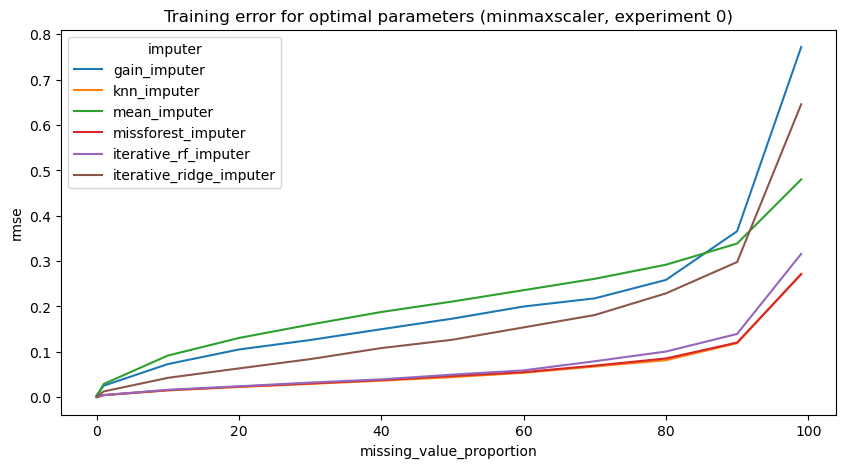

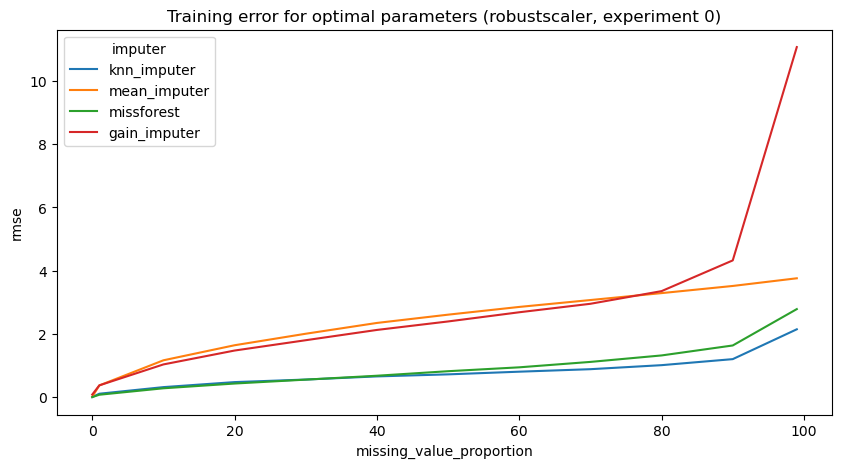

In [108]:
# training error exp0
experiment_no = 0
plt.rcParams["figure.figsize"] = (10, 5)

for scaler, info in scalers.items():
    dfs = info["dfres"][(info["dfres"]["experiment"] == experiment_no)]

    sns.lineplot(data=dfs, x="missing_value_proportion", y="rmse", hue="imputer")
    plt.title(f"Training error for optimal parameters ({scaler}, experiment {experiment_no})")
    plt.savefig(f"{info['output_path']}tuning_error_{experiment_no}.png")
    plt.show()

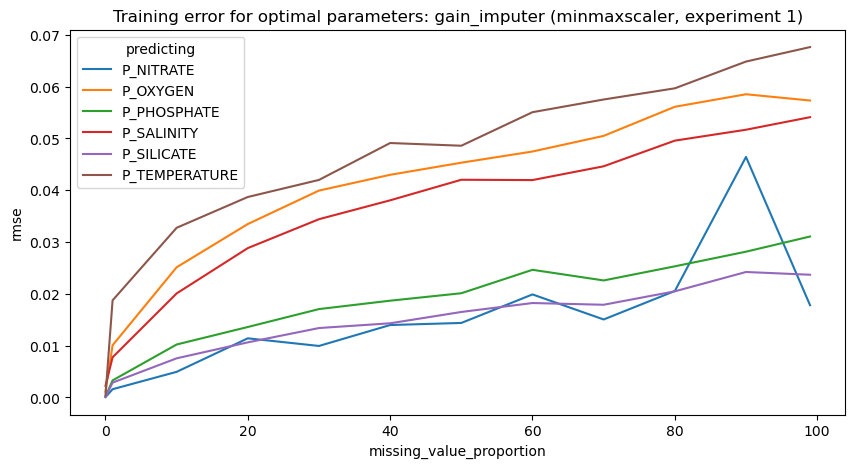

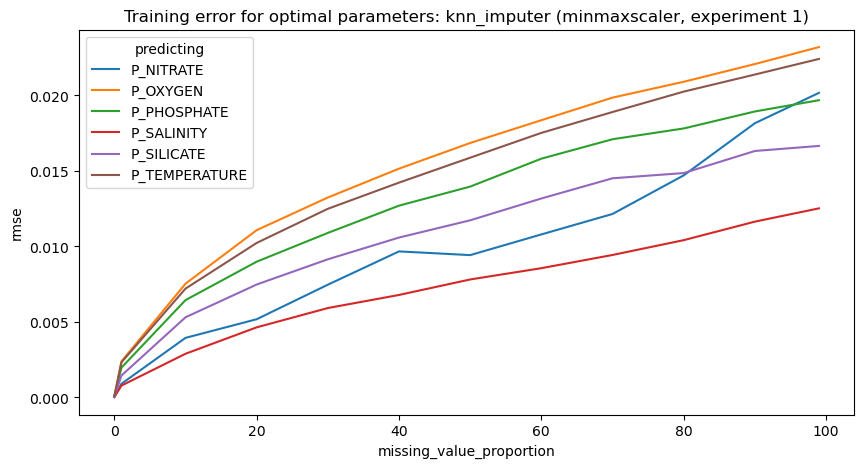

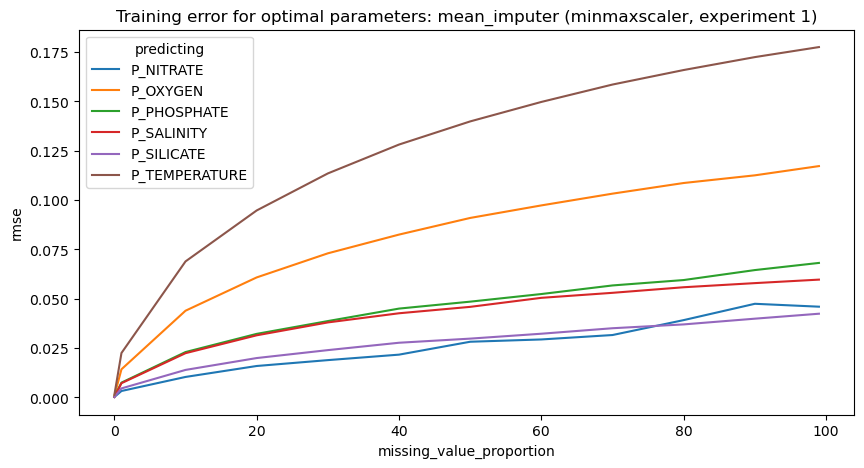

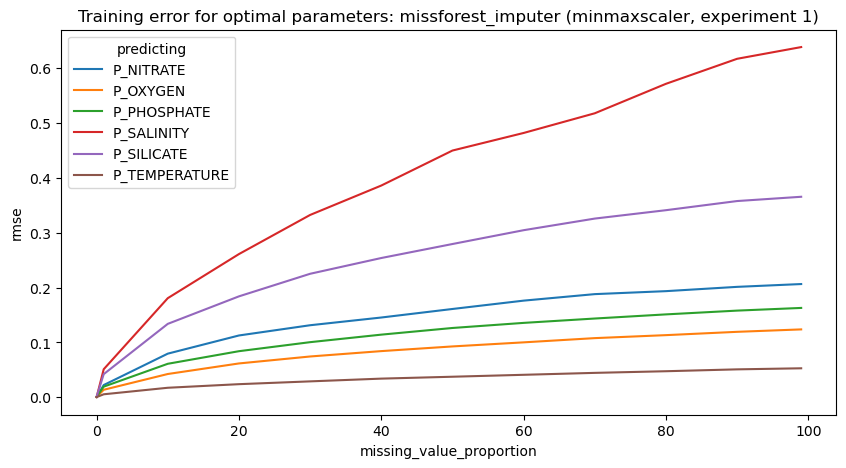

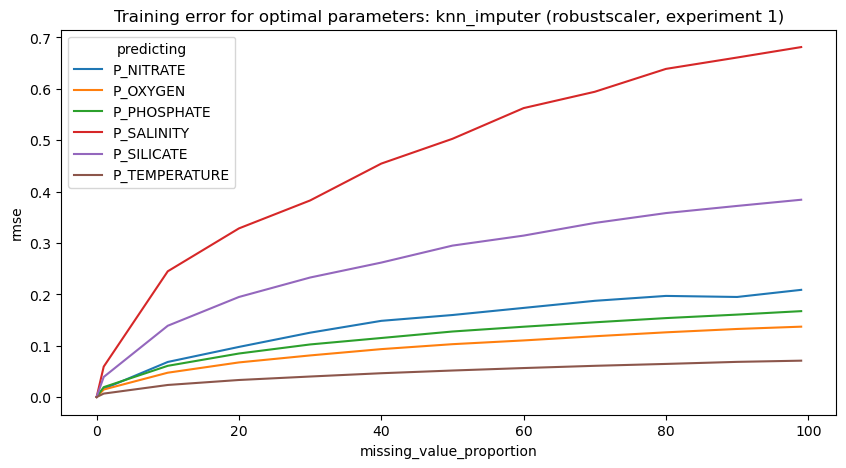

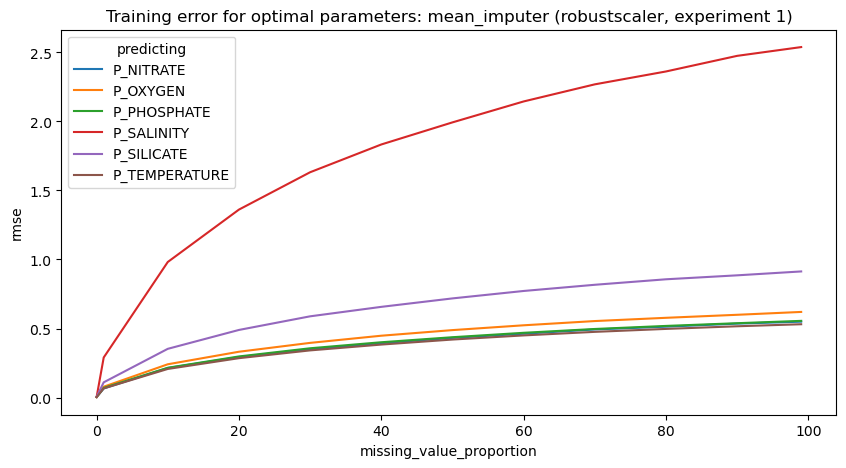

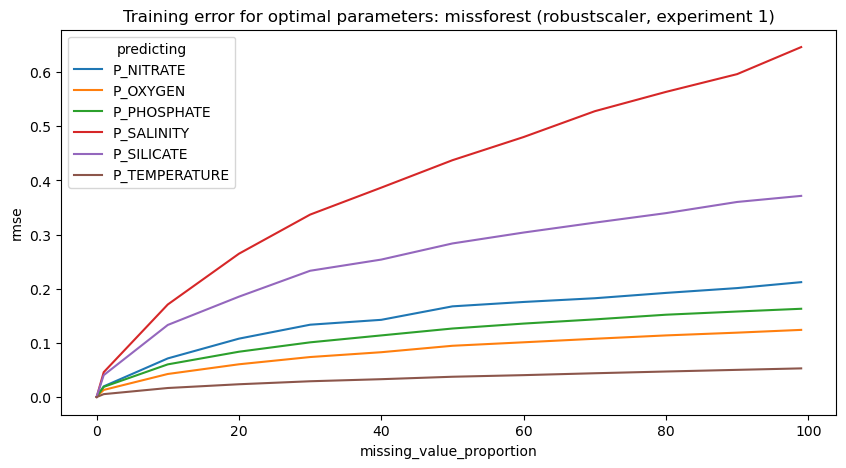

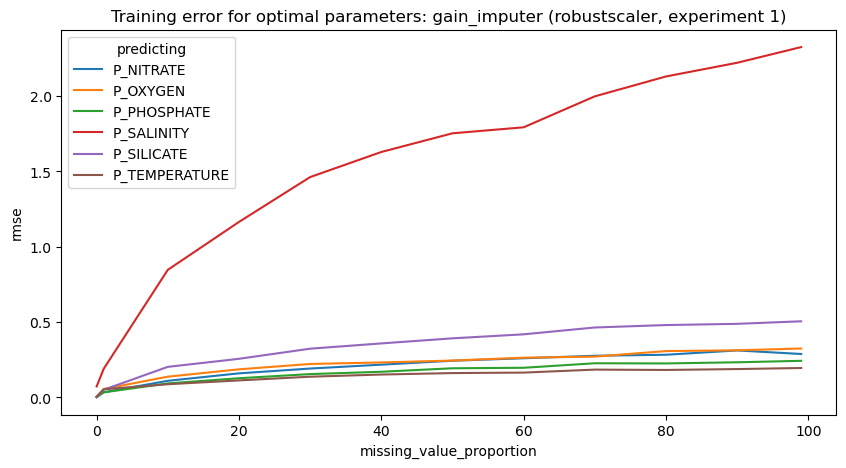

In [5]:
# training error exp1
experiment_no = 1
plt.rcParams["figure.figsize"] = (10, 5)

for scaler, info in scalers.items():
    for imputer in info["dfres"]["imputer"].unique():
        dfs = info["dfres"][(info["dfres"]["imputer"] == imputer) & (info["dfres"]["experiment"] == experiment_no)]

        sns.lineplot(data=dfs, x="missing_value_proportion", y="rmse", hue="predicting")
        plt.title(f"Training error for optimal parameters: {imputer} ({scaler}, experiment {experiment_no})")
        plt.savefig(f"{info['output_path']}tuning_error_{imputer}{experiment_no}.png")
        plt.show()

### Plot optimal hyperparameter combinations

In [119]:
# relevant hyperparameters
rel_hyps = {"gain_imputer": {"alpha": "Alpha", "hint_rate": "Hint rate"},
           "mean_imputer": {},
           "knn_imputer": {"n_neighbors": "Number of neighbors", "weights": "Weight"},
           "missforest_imputer": {"n_estimators": "Number of trees"},
           "iterative_rf_imputer": {"estimator": "Number of trees"},
           "iterative_ridge_imputer": {"max_iter": "Max. iterations"}}

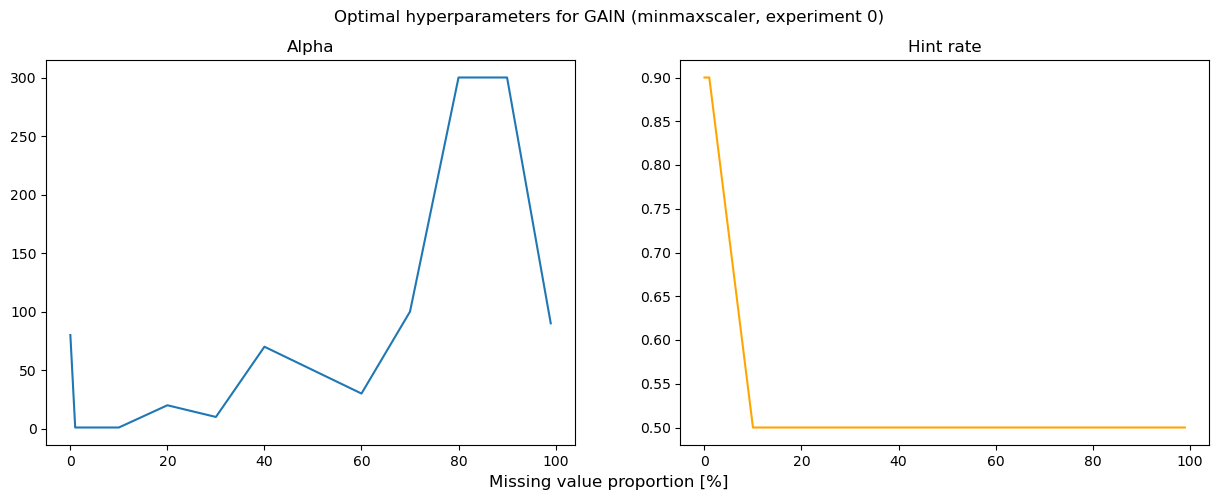

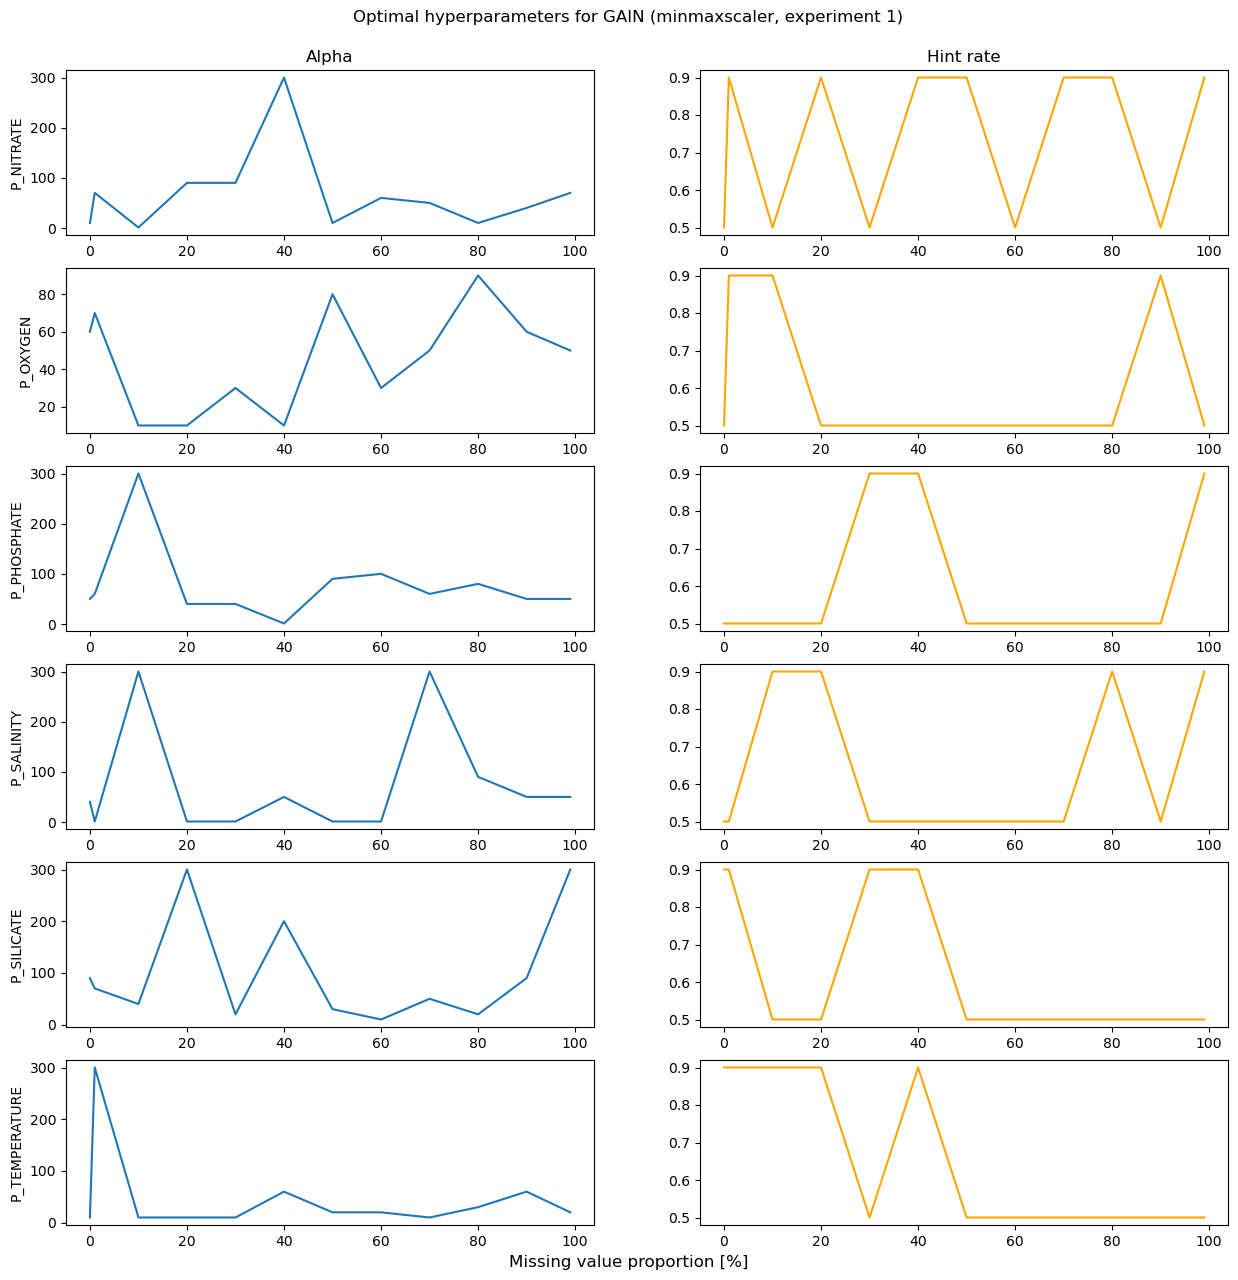

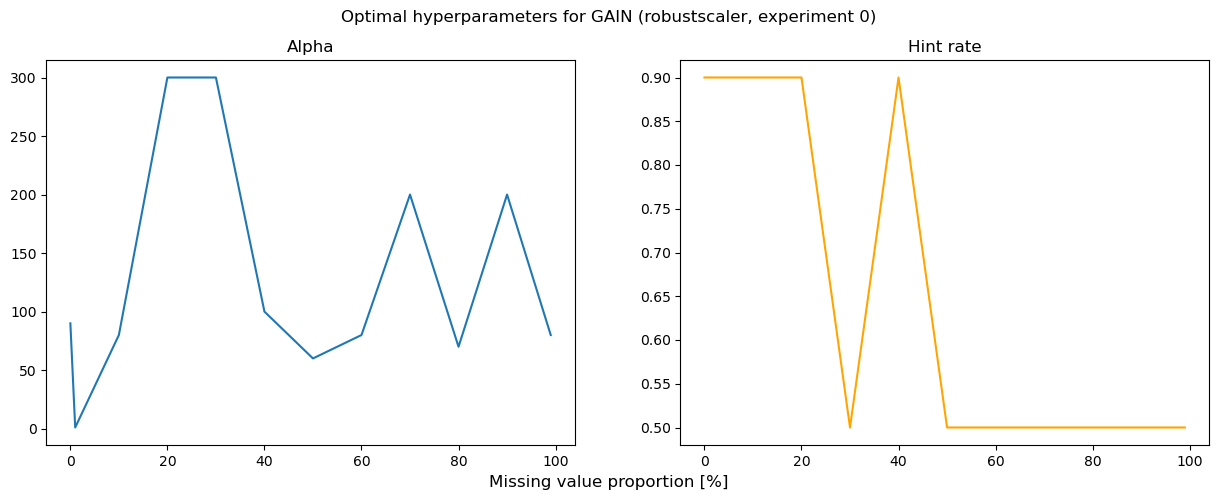

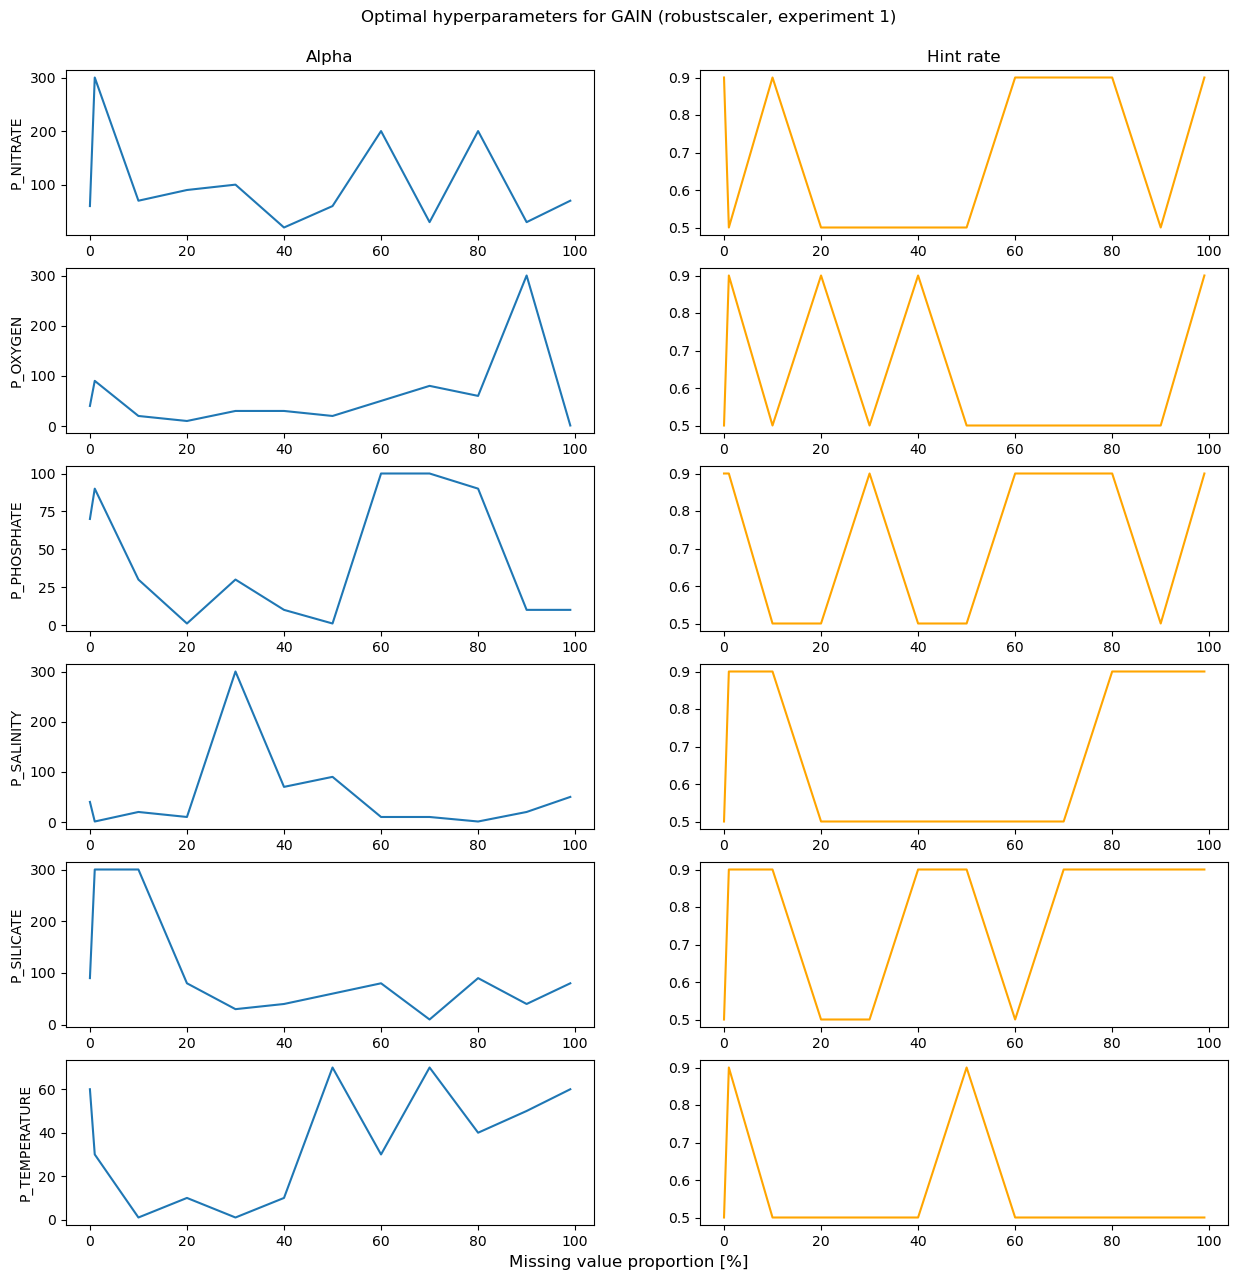

In [77]:
# GAIN plot
imputer_name = "gain_imputer"
for scaler, info in scalers.items():
    plt.rcParams["figure.figsize"] = (15, 5)
    experiment_no = 0
    info = scalers[scaler]
    info["dfres"].replace({"missforest": "missforest_imputer"}, inplace=True)
    temp = info["dfres"][(info["dfres"]["imputer"] == imputer_name) & 
                         (info["dfres"]["experiment"] == experiment_no)]

       
    fig, axs = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(f"Optimal hyperparameters for GAIN ({scaler}, experiment {experiment_no})", y=0.98)
    fig.supxlabel("Missing value proportion [%]", y=0.02)
    axs[0].plot(t["missing_value_proportion"], temp["alpha"])  
    axs[1].plot(t["missing_value_proportion"], temp["hint_rate"], color="orange")
    axs[0].set_title("Alpha")
    axs[1].title.set_text("Hint rate")
    plt.savefig(f"{info['output_path']}optimal_hyperparameters_gain_imputer_{scaler}_{experiment_no}.png")
    plt.show()
    
    
    experiment_no = 1
    plt.rcParams["figure.figsize"] = (15, 15)
    temp = info["dfres"][(info["dfres"]["imputer"] == imputer_name) & 
                         (info["dfres"]["experiment"] == experiment_no)]   
    parameters = list(temp["predicting"].unique())
    
    fig, axs = plt.subplots(nrows=len(parameters), ncols=2)
    fig.suptitle(f"Optimal hyperparameters for GAIN ({scaler}, experiment {experiment_no})", y=0.92)
    fig.supxlabel("Missing value proportion [%]", y=0.08)
    axs = axs.flatten()
    i = 0
    for param in parameters:
        t = temp[(temp["predicting"] == param)]
        axs[i].plot(t["missing_value_proportion"], t["alpha"])  
        axs[i].set_ylabel(param)
        axs[i+1].plot(t["missing_value_proportion"], t["hint_rate"], color="orange")
        i = i + 2
    axs[0].set_title("Alpha")
    axs[1].title.set_text("Hint rate")
    plt.savefig(f"{info['output_path']}optimal_hyperparameters_gain_imputer_{scaler}_{experiment_no}.png")
    plt.show()    

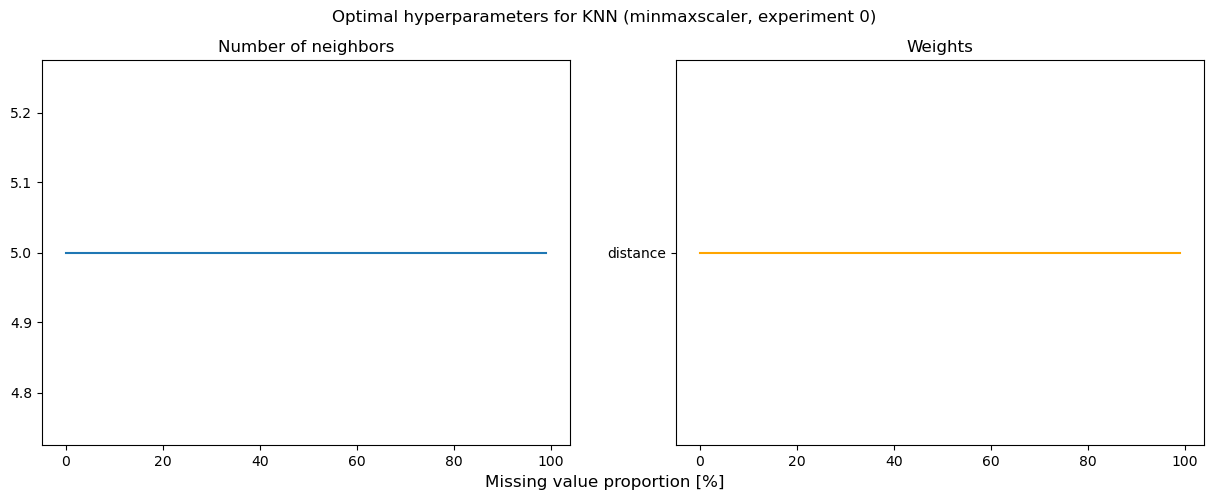

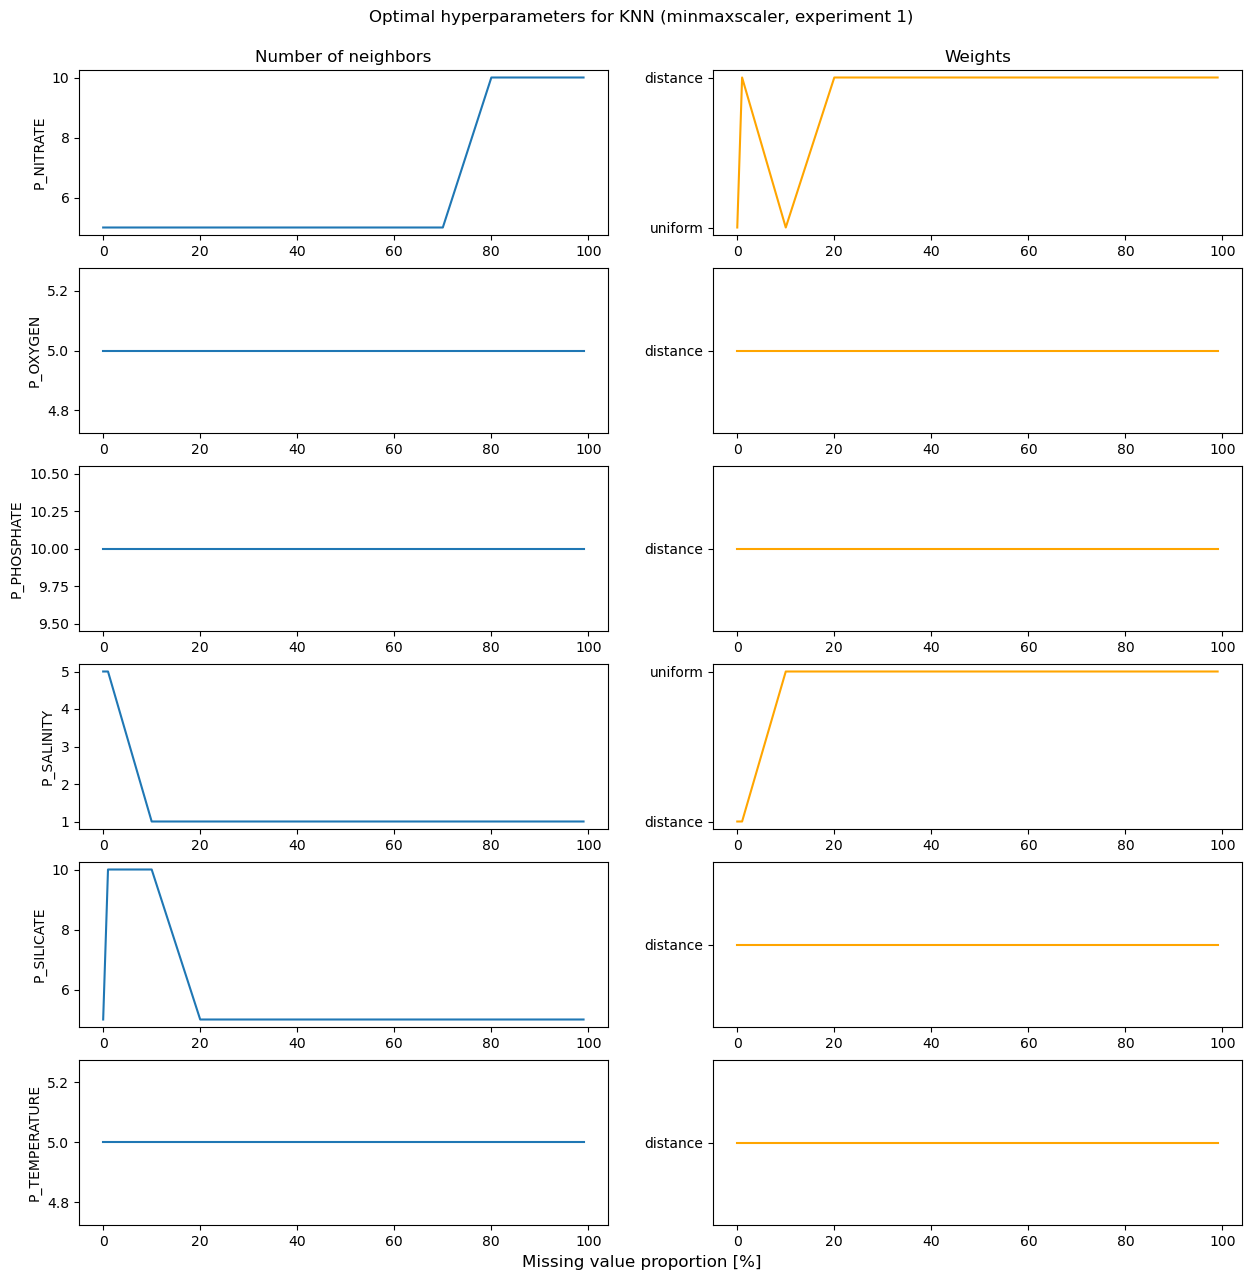

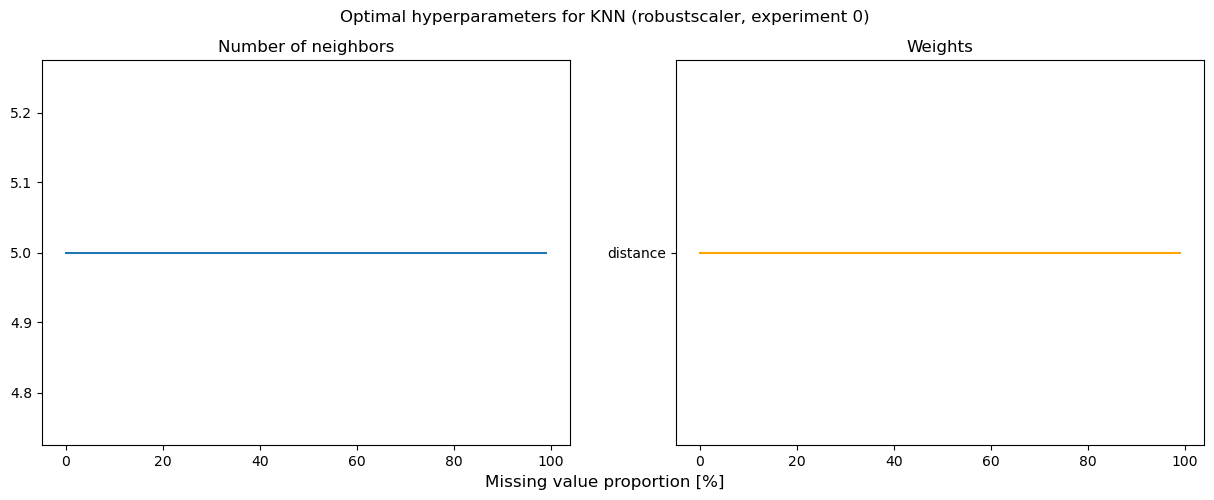

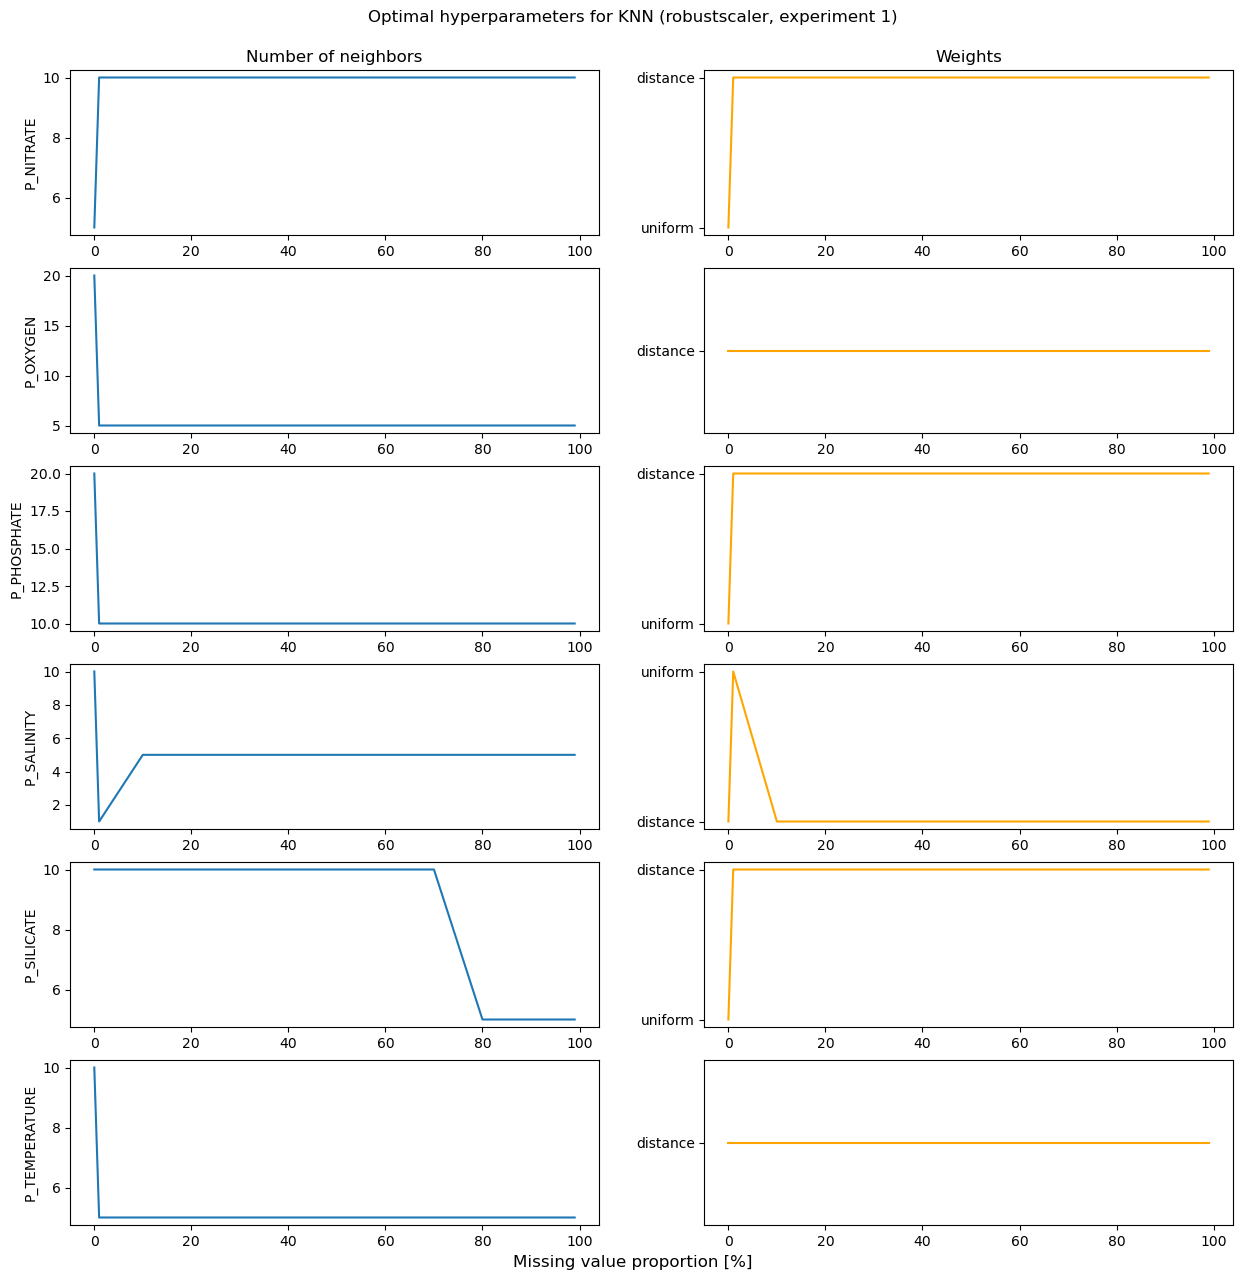

In [88]:
# knn plot
imputer_name = "knn_imputer"
for scaler, info in scalers.items():
    plt.rcParams["figure.figsize"] = (15, 5)
    experiment_no = 0
    info = scalers[scaler]
    info["dfres"].replace({"missforest": "missforest_imputer"}, inplace=True)
    temp = info["dfres"][(info["dfres"]["imputer"] == imputer_name) & 
                         (info["dfres"]["experiment"] == experiment_no)]

       
    fig, axs = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(f"Optimal hyperparameters for KNN ({scaler}, experiment {experiment_no})", y=0.98)
    fig.supxlabel("Missing value proportion [%]", y=0.02)
    axs[0].plot(t["missing_value_proportion"], temp["n_neighbors"])  
    axs[1].plot(t["missing_value_proportion"], temp["weights"], color="orange")
    axs[0].set_title("Number of neighbors")
    axs[1].title.set_text("Weights")
    plt.savefig(f"{info['output_path']}optimal_hyperparameters_{imputer_name}_{scaler}_{experiment_no}.png")
    plt.show()
    
    
    experiment_no = 1
    plt.rcParams["figure.figsize"] = (15, 15)
    temp = info["dfres"][(info["dfres"]["imputer"] == imputer_name) & 
                         (info["dfres"]["experiment"] == experiment_no)]   
    parameters = list(temp["predicting"].unique())
    
    fig, axs = plt.subplots(nrows=len(parameters), ncols=2)
    fig.suptitle(f"Optimal hyperparameters for KNN ({scaler}, experiment {experiment_no})", y=0.92)
    fig.supxlabel("Missing value proportion [%]", y=0.08)
    axs = axs.flatten()
    i = 0
    for param in parameters:
        t = temp[(temp["predicting"] == param)]
        axs[i].plot(t["missing_value_proportion"], t["n_neighbors"])  
        axs[i].set_ylabel(param)
        axs[i+1].plot(t["missing_value_proportion"], t["weights"], color="orange")
        i = i + 2
    axs[0].set_title("Number of neighbors")
    axs[1].title.set_text("Weights")
    plt.savefig(f"{info['output_path']}optimal_hyperparameters_{imputer_name}_{scaler}_{experiment_no}.png")
    plt.show()    

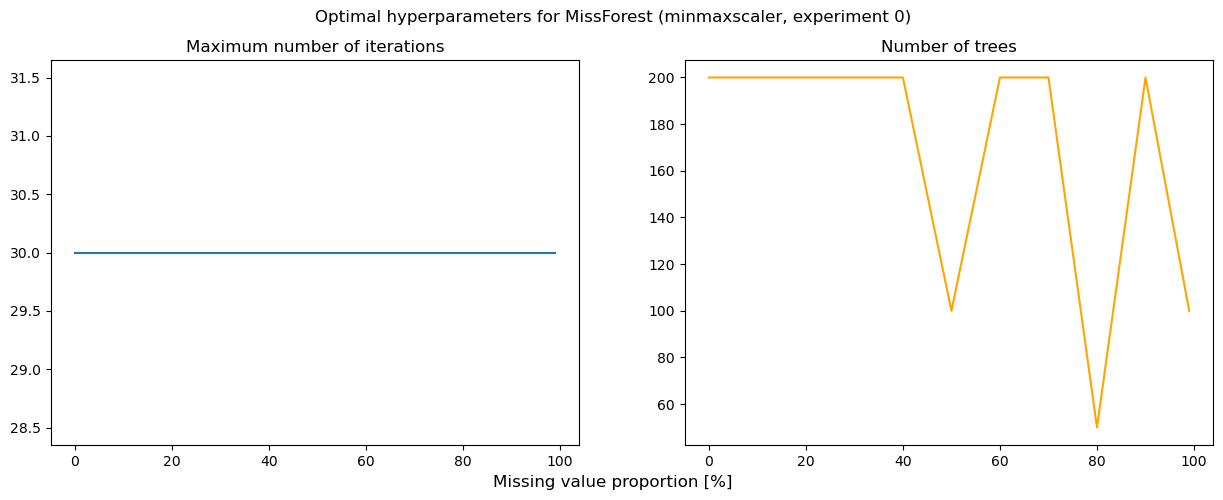

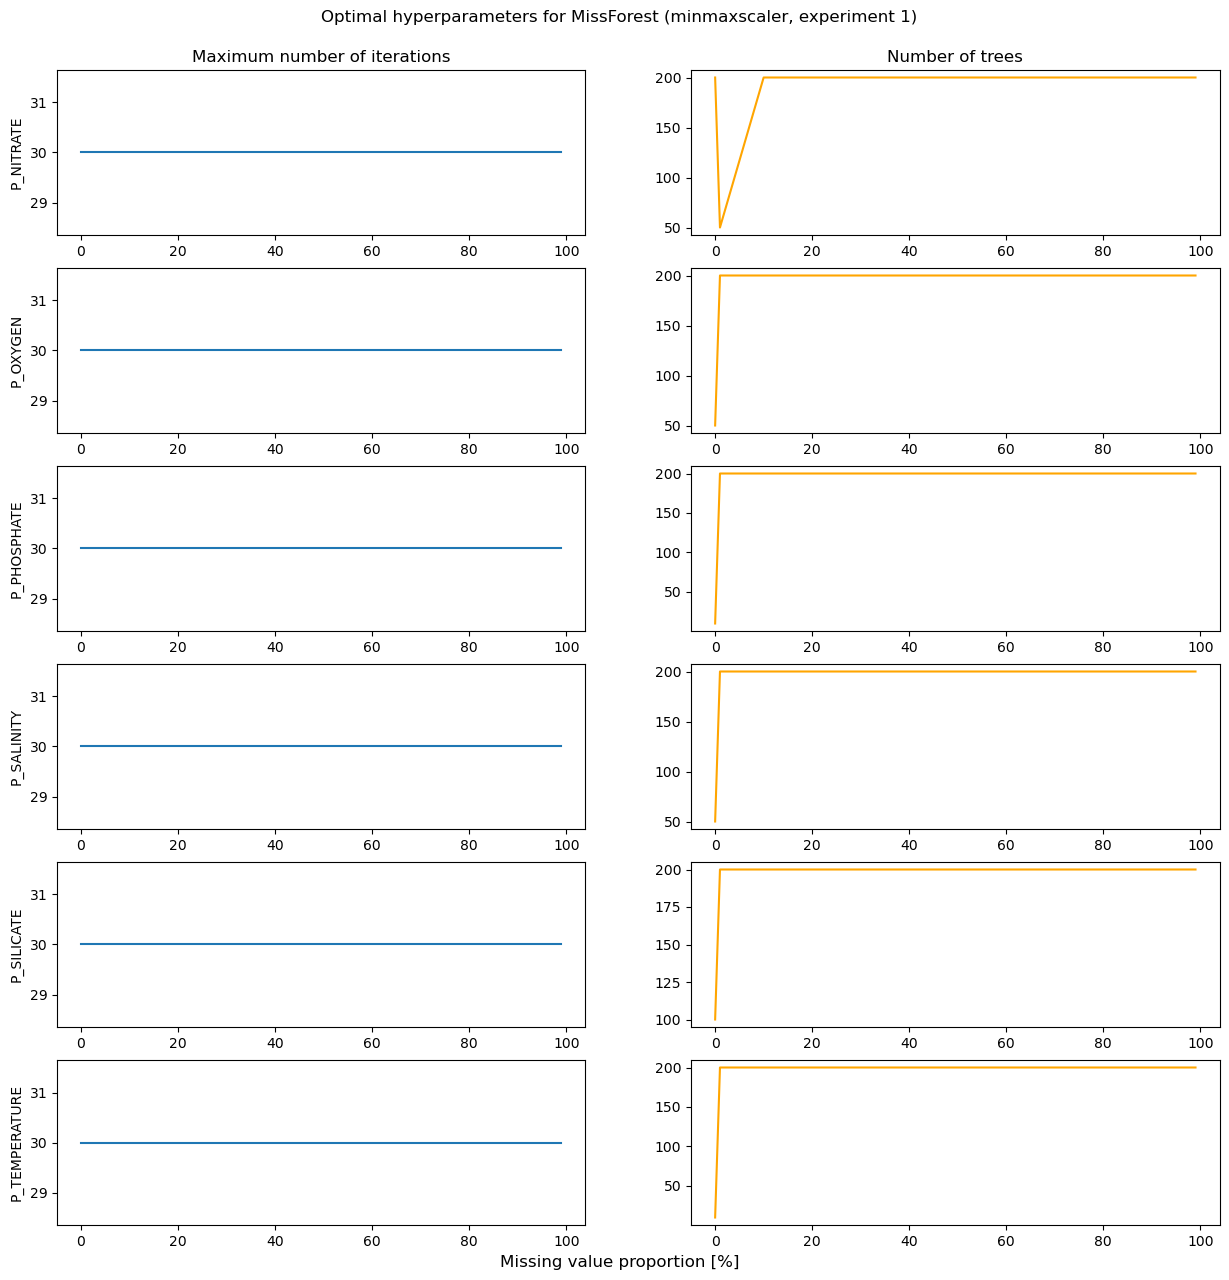

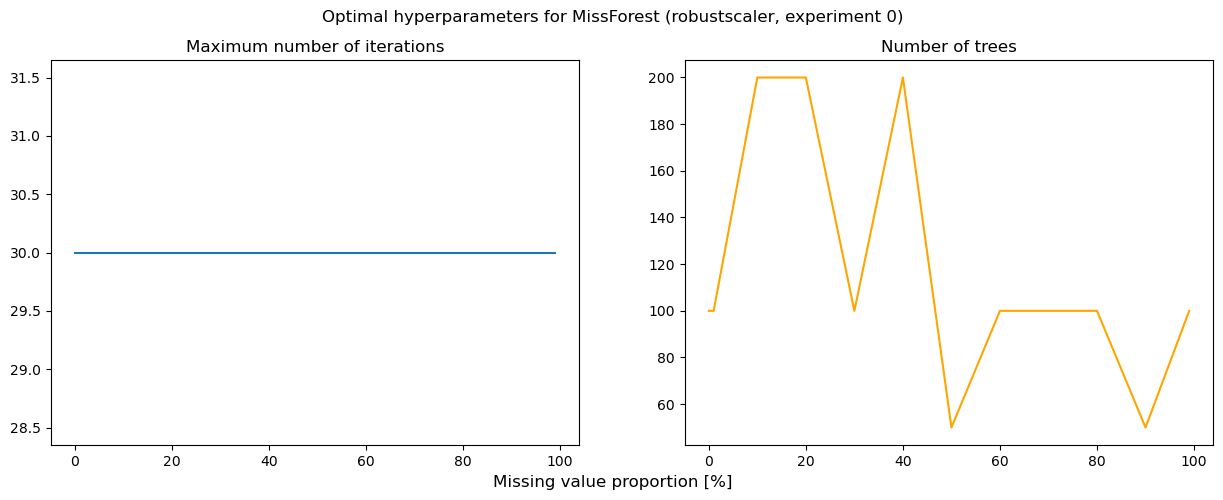

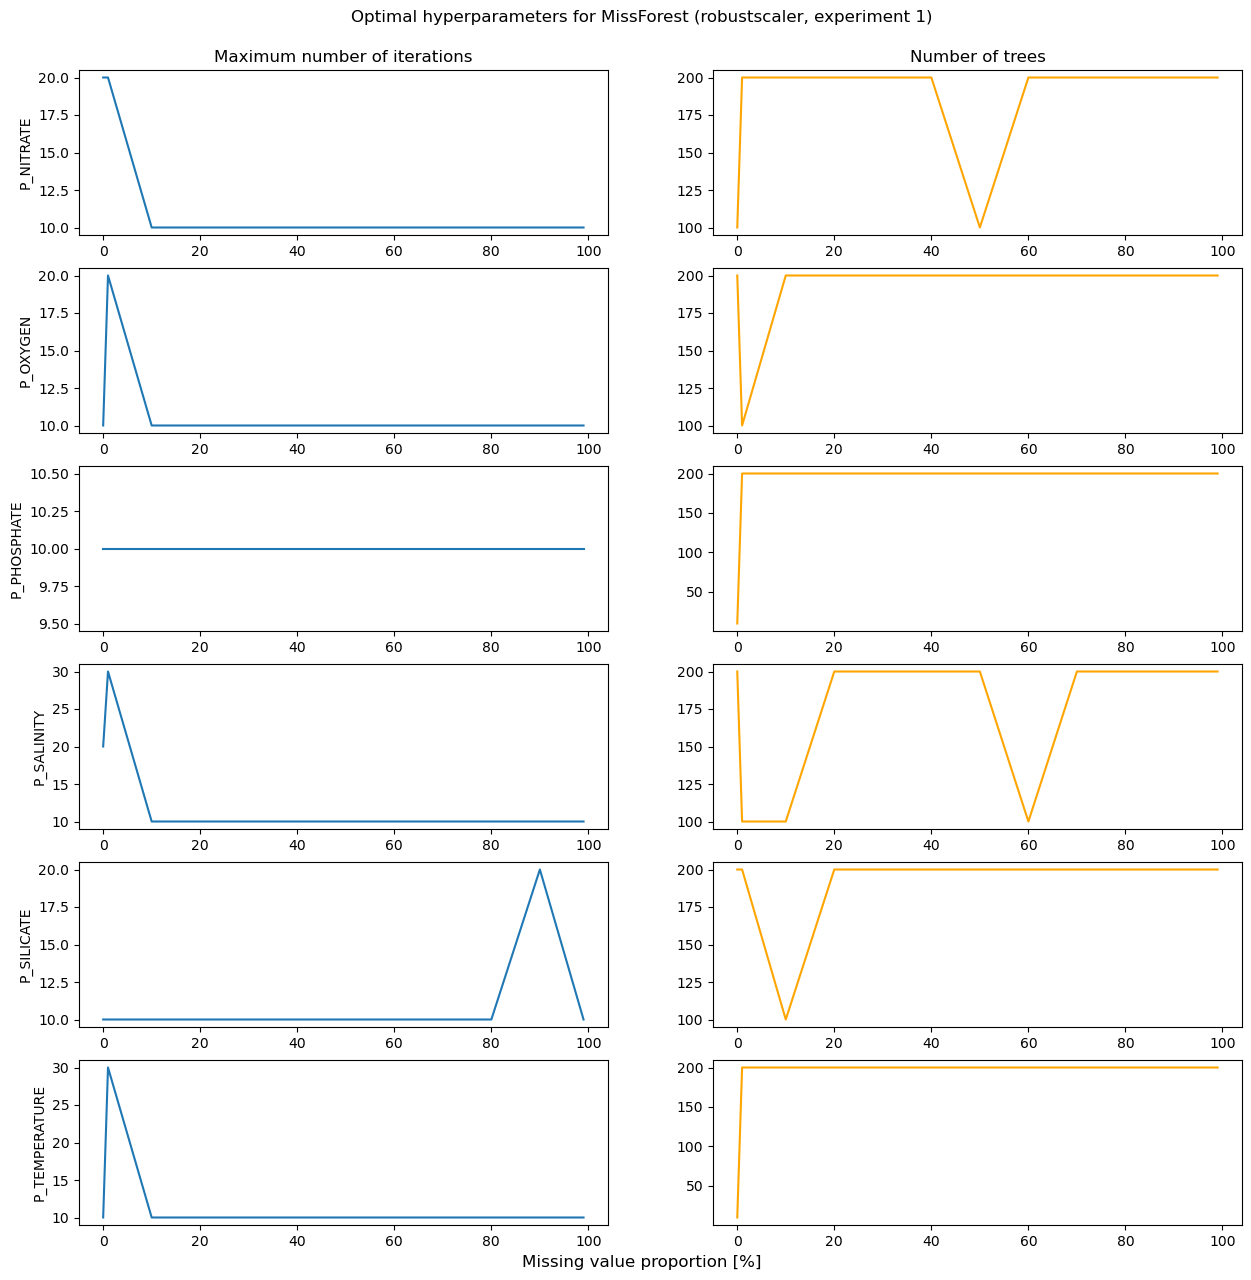

In [91]:
# missforest plot
imputer_name = "missforest_imputer"
for scaler, info in scalers.items():
    plt.rcParams["figure.figsize"] = (15, 5)
    experiment_no = 0
    info = scalers[scaler]
    info["dfres"].replace({"missforest": "missforest_imputer"}, inplace=True)
    temp = info["dfres"][(info["dfres"]["imputer"] == imputer_name) & 
                         (info["dfres"]["experiment"] == experiment_no)]

       
    fig, axs = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(f"Optimal hyperparameters for MissForest ({scaler}, experiment {experiment_no})", y=0.98)
    fig.supxlabel("Missing value proportion [%]", y=0.02)
    axs[0].plot(t["missing_value_proportion"], temp["max_iter"])  
    axs[1].plot(t["missing_value_proportion"], temp["n_estimators"], color="orange")
    axs[0].set_title("Maximum number of iterations")
    axs[1].set_title("Number of trees")
    plt.savefig(f"{info['output_path']}optimal_hyperparameters_{imputer_name}_{scaler}_{experiment_no}.png")
    plt.show()
    
    
    experiment_no = 1
    plt.rcParams["figure.figsize"] = (15, 15)
    temp = info["dfres"][(info["dfres"]["imputer"] == imputer_name) & 
                         (info["dfres"]["experiment"] == experiment_no)]   
    parameters = list(temp["predicting"].unique())
    
    fig, axs = plt.subplots(nrows=len(parameters), ncols=2)
    fig.suptitle(f"Optimal hyperparameters for MissForest ({scaler}, experiment {experiment_no})", y=0.92)
    fig.supxlabel("Missing value proportion [%]", y=0.08)
    axs = axs.flatten()
    i = 0
    for param in parameters:
        t = temp[(temp["predicting"] == param)]
        axs[i].plot(t["missing_value_proportion"], t["max_iter"])  
        axs[i].set_ylabel(param)
        axs[i+1].plot(t["missing_value_proportion"], t["n_estimators"], color="orange")
        i = i + 2
    axs[0].set_title("Maximum number of iterations")
    axs[1].title.set_text("Number of trees")
    plt.savefig(f"{info['output_path']}optimal_hyperparameters_{imputer_name}_{scaler}_{experiment_no}.png")
    plt.show()    

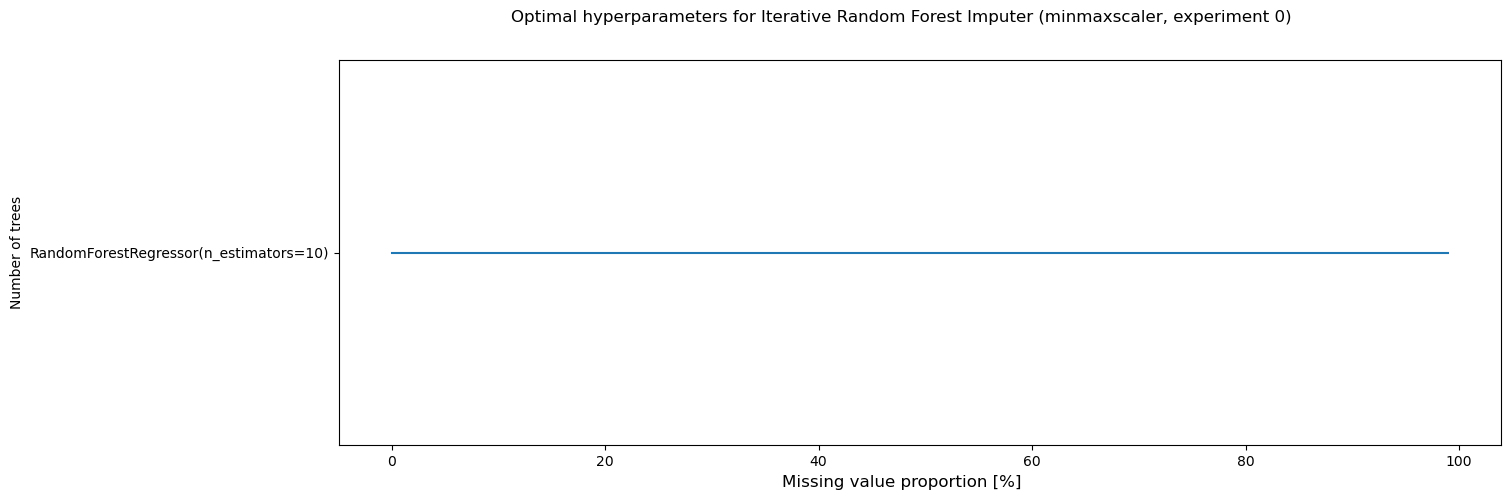

In [125]:
# iterative RF plot
imputer_name = "iterative_rf_imputer"

plt.rcParams["figure.figsize"] = (15, 5)
experiment_no = 0
info = scalers[scaler]
info["dfres"].replace({"missforest": "missforest_imputer"}, inplace=True)
temp = info["dfres"][(info["dfres"]["imputer"] == imputer_name) & 
                     (info["dfres"]["experiment"] == experiment_no)]


fig, axs = plt.subplots(nrows=1, ncols=1)
fig.suptitle(f"Optimal hyperparameters for Iterative Random Forest Imputer ({scaler}, experiment {experiment_no})", y=0.98)
fig.supxlabel("Missing value proportion [%]", y=0.02)
axs.plot(temp["missing_value_proportion"], temp["estimator"])  
axs.set_ylabel("Number of trees")
plt.savefig(f"{info['output_path']}optimal_hyperparameters_{imputer_name}_{scaler}_{experiment_no}.png")
plt.show()

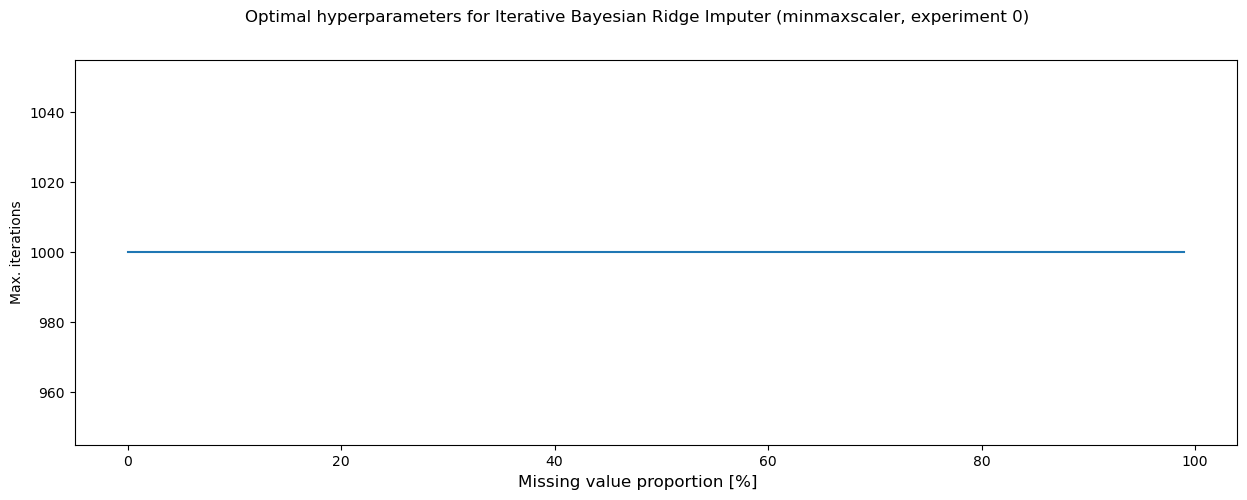

In [122]:
# iterative Bayesian plot
imputer_name = "iterative_ridge_imputer"

plt.rcParams["figure.figsize"] = (15, 5)
experiment_no = 0
info = scalers[scaler]
info["dfres"].replace({"missforest": "missforest_imputer"}, inplace=True)
temp = info["dfres"][(info["dfres"]["imputer"] == imputer_name) & 
                     (info["dfres"]["experiment"] == experiment_no)]

fig, axs = plt.subplots(nrows=1, ncols=1)
fig.suptitle(f"Optimal hyperparameters for Iterative Bayesian Ridge Imputer ({scaler}, experiment {experiment_no})", y=0.98)
fig.supxlabel("Missing value proportion [%]", y=0.02)
axs.plot(temp["missing_value_proportion"], temp["max_iter"])  
axs.set_ylabel("Max. iterations")
plt.savefig(f"{info['output_path']}optimal_hyperparameters_{imputer_name}_{scaler}_{experiment_no}.png")
plt.show()

gain_imputer


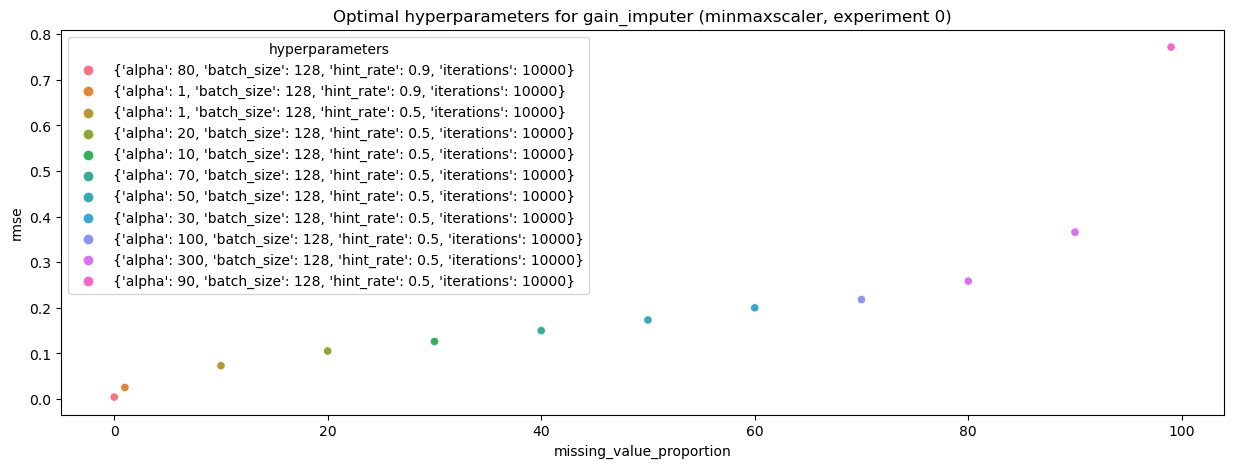

knn_imputer


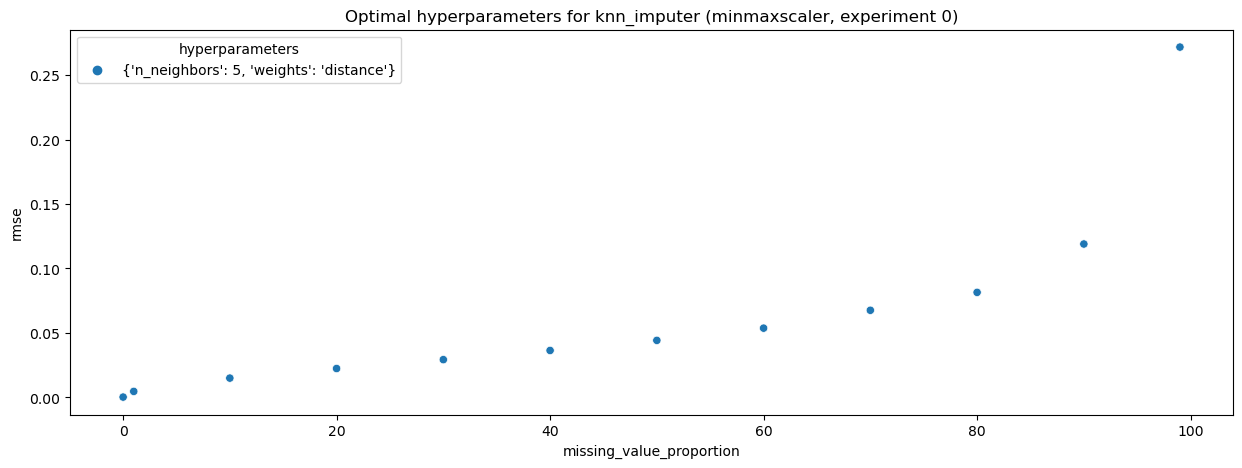

mean_imputer


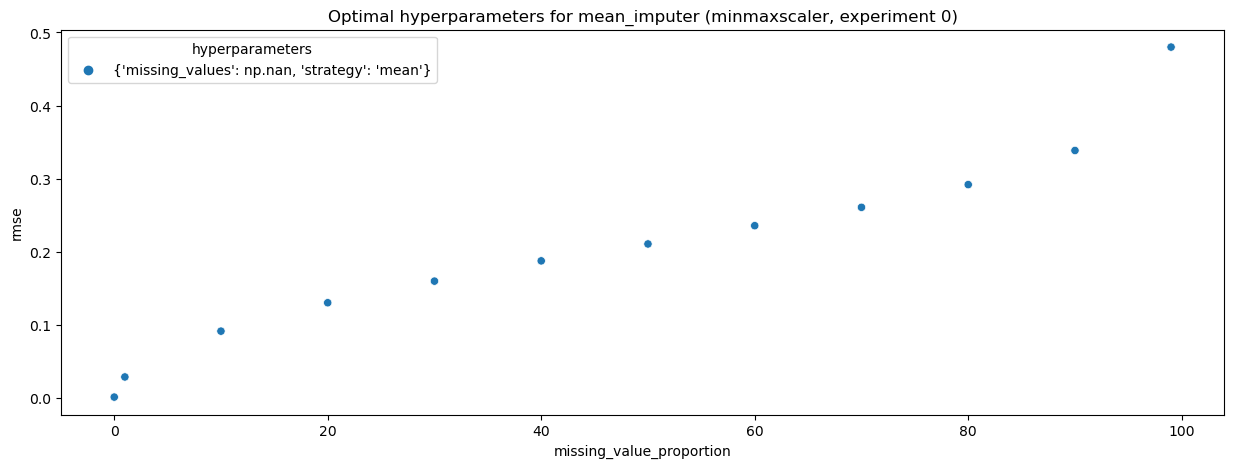

missforest_imputer


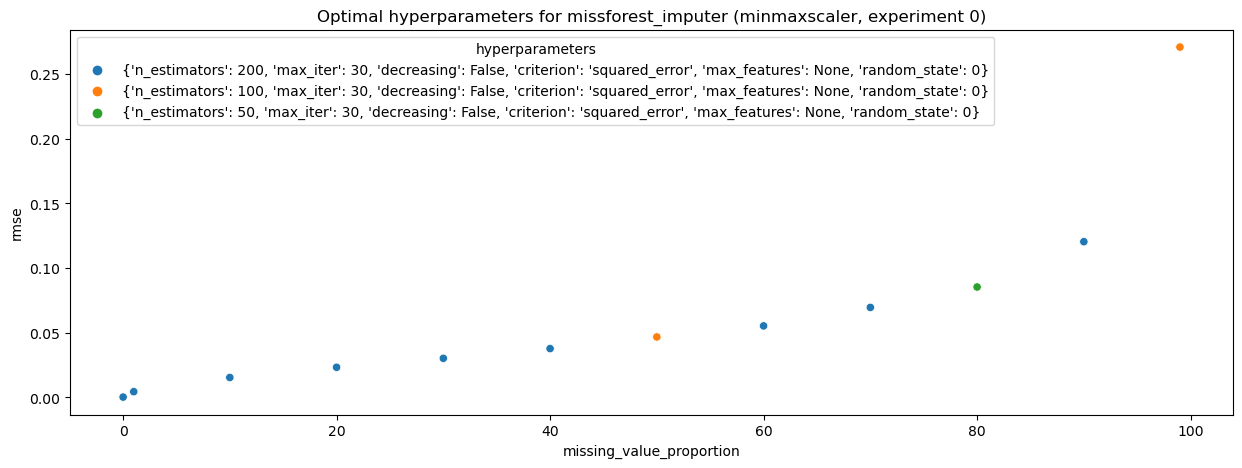

gain_imputer


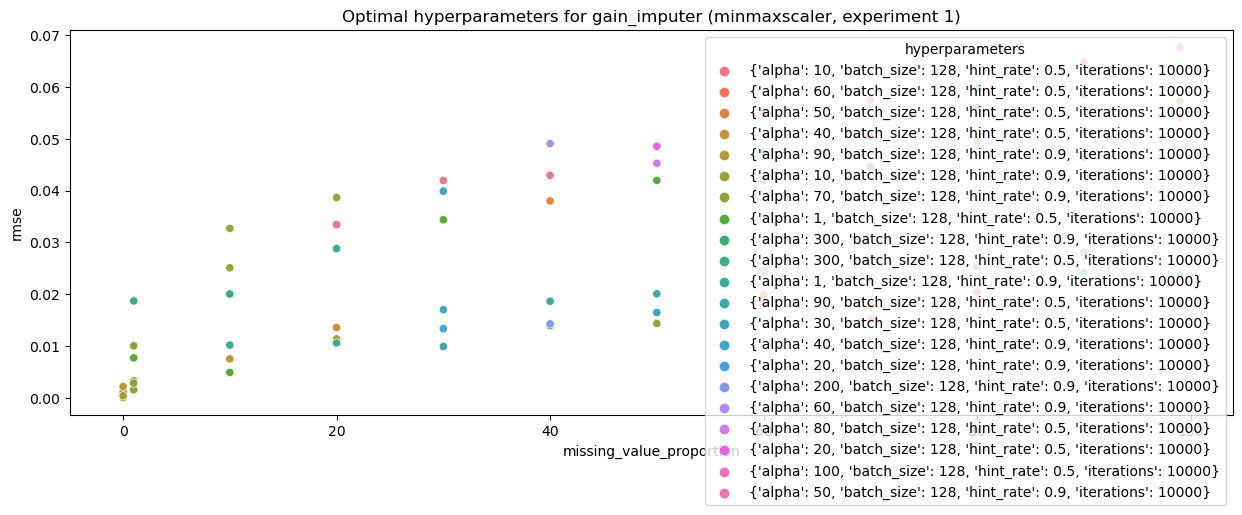

knn_imputer


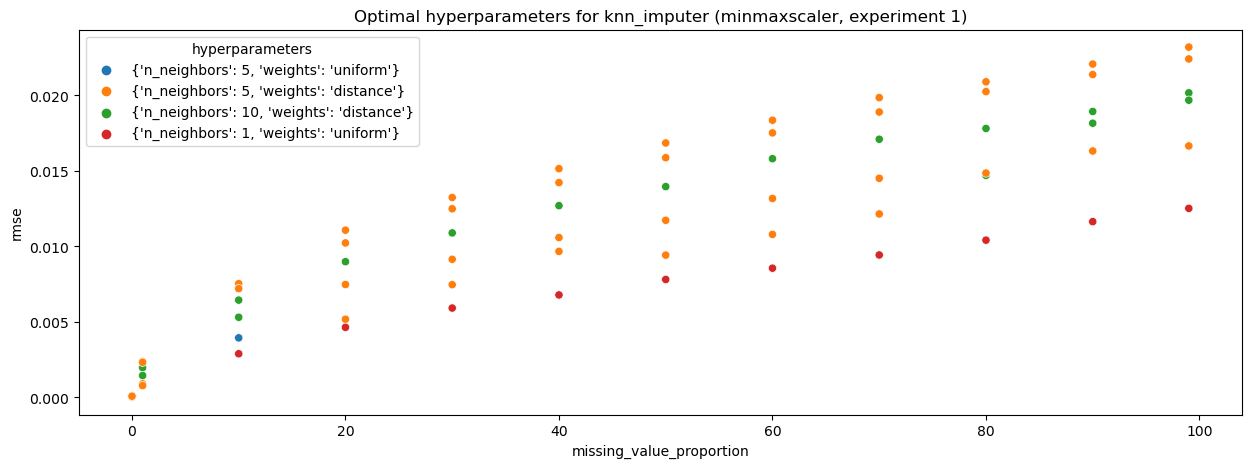

mean_imputer


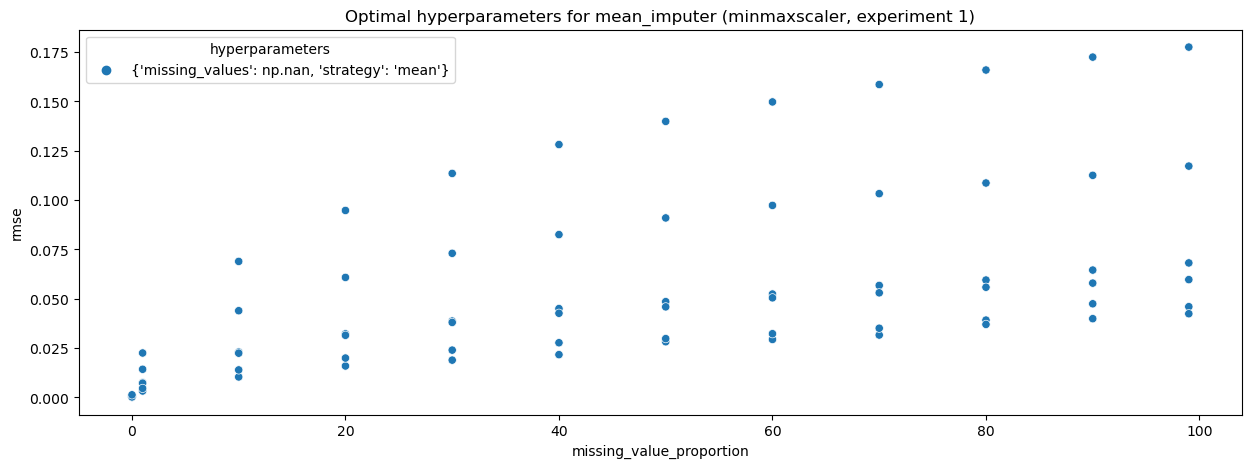

missforest_imputer


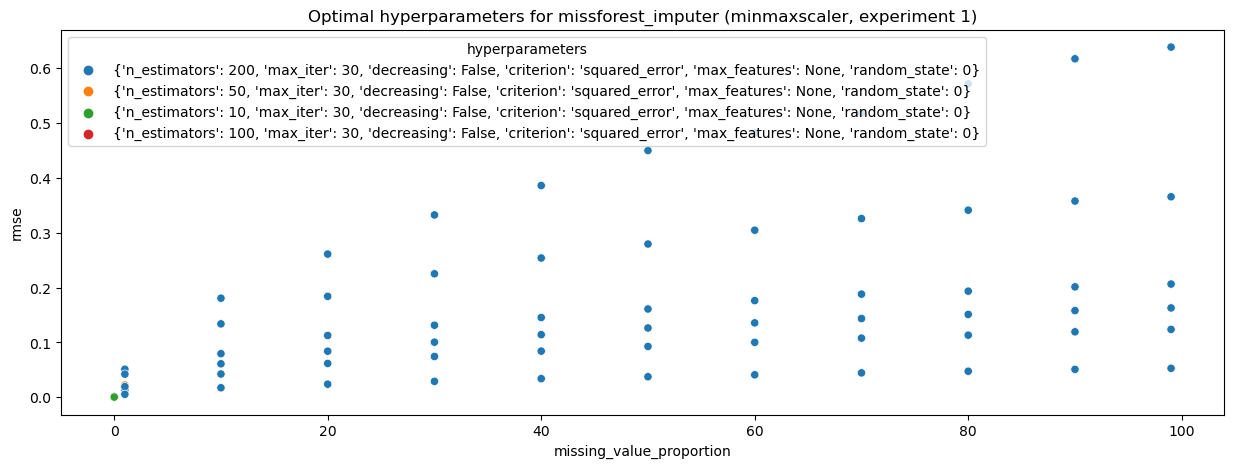

knn_imputer


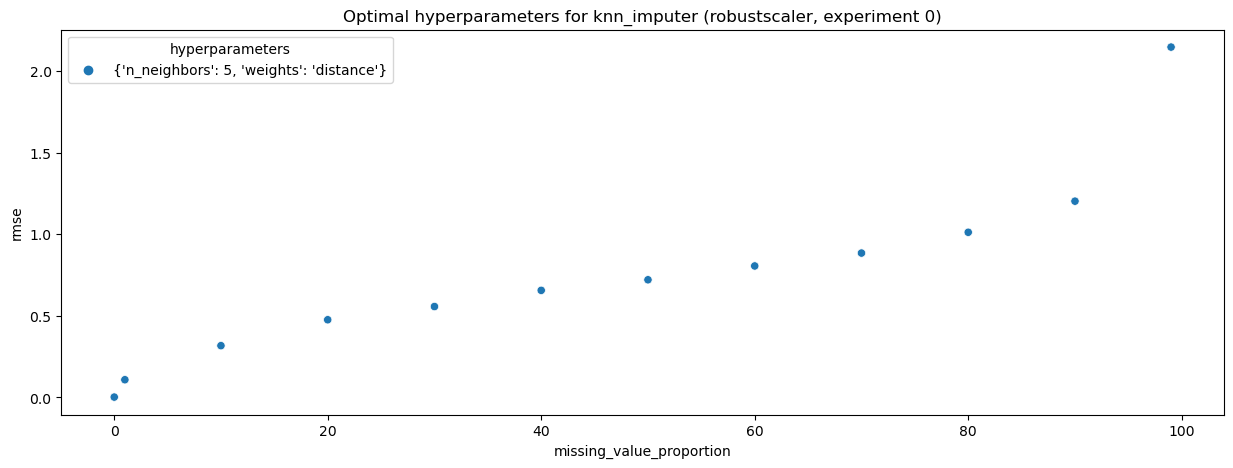

mean_imputer


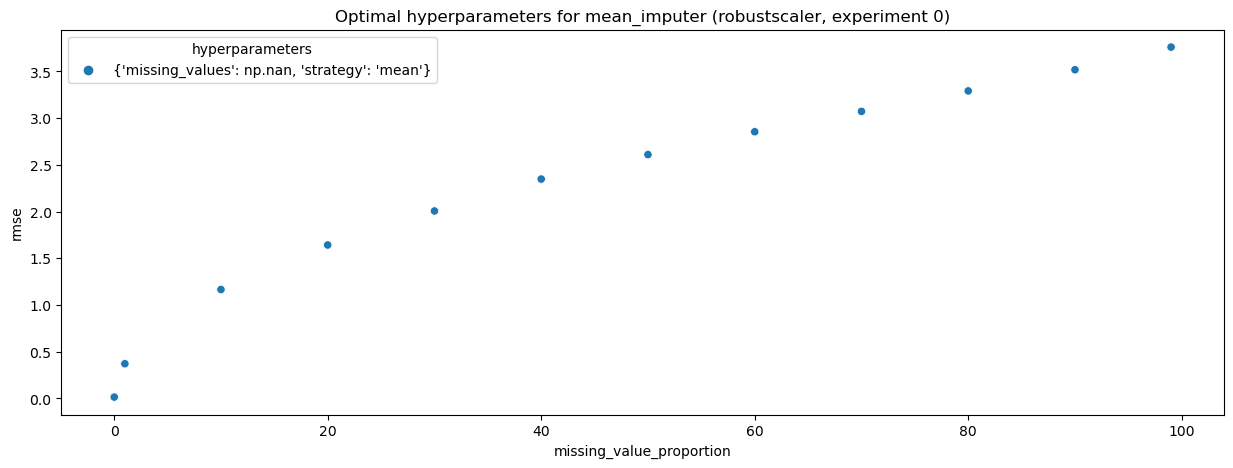

missforest_imputer


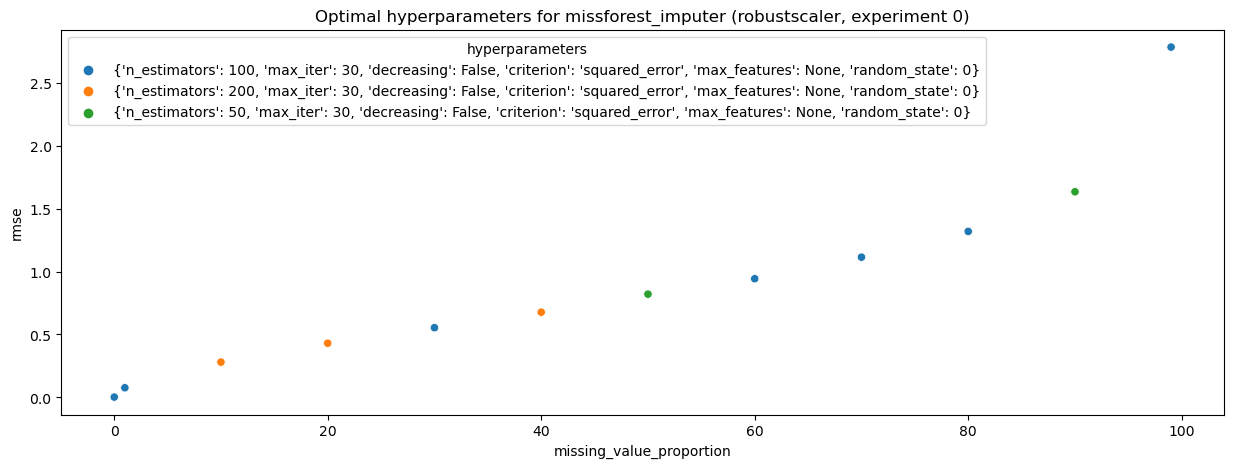

gain_imputer


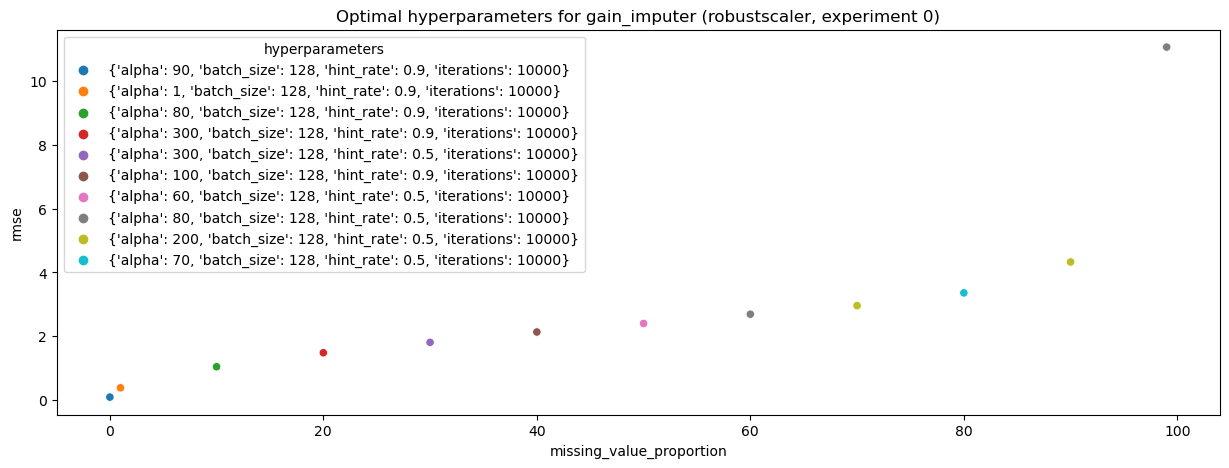

knn_imputer


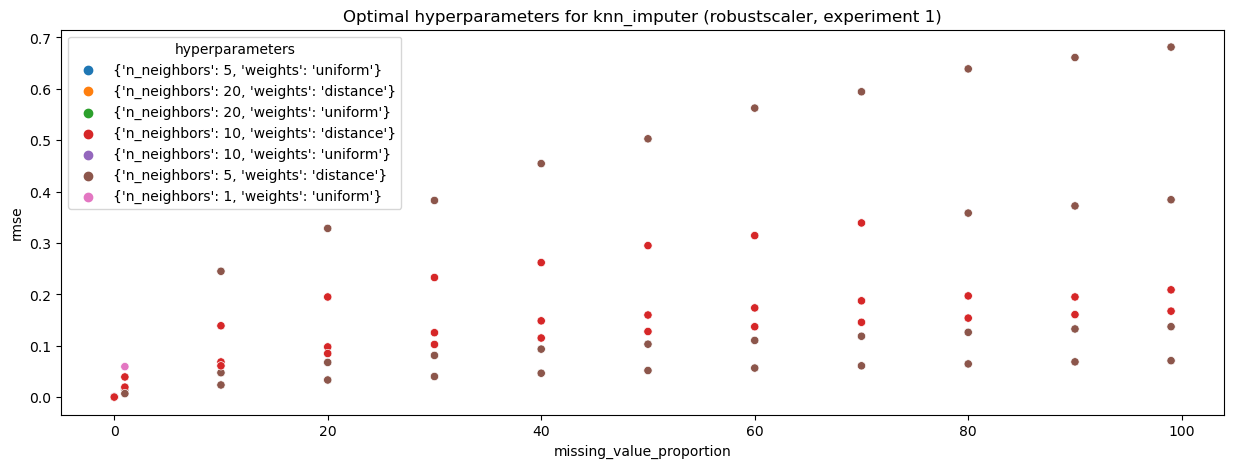

mean_imputer


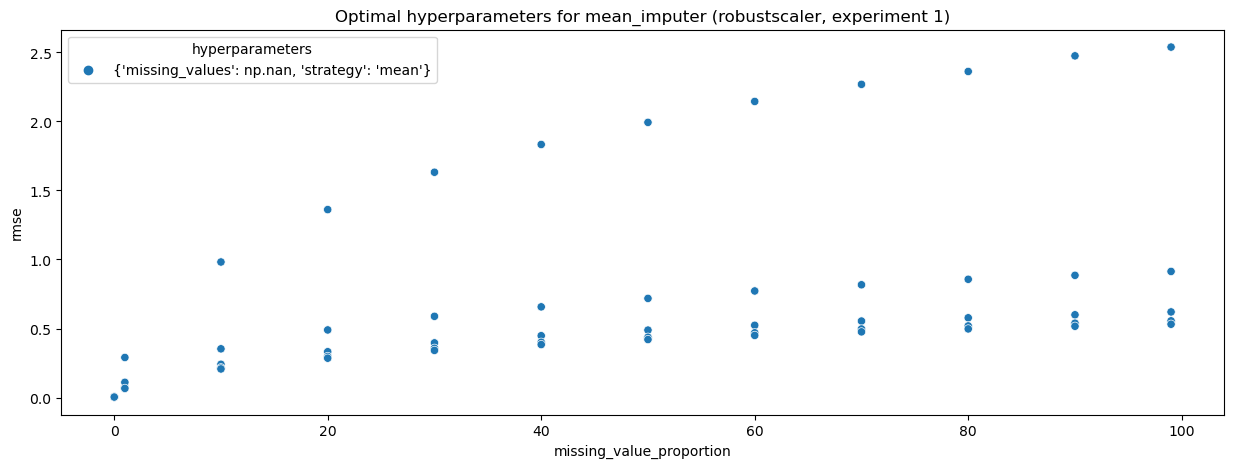

missforest_imputer


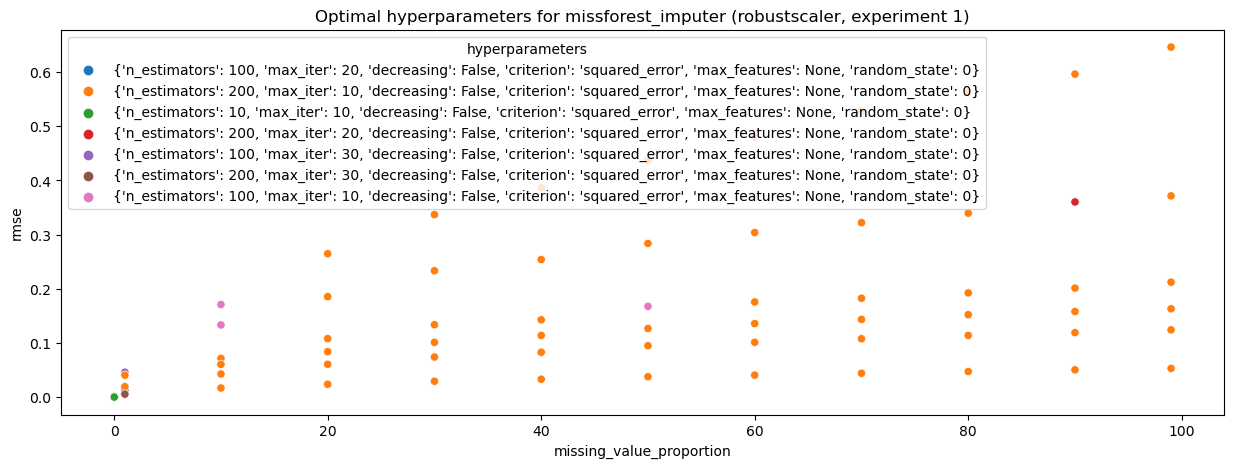

gain_imputer


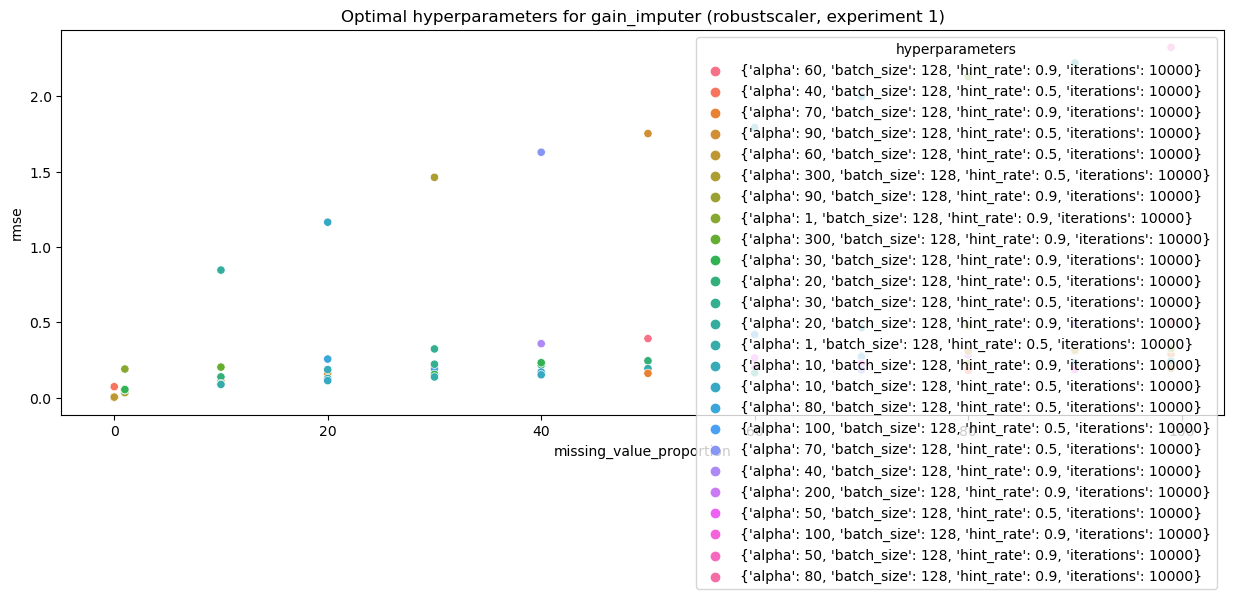

In [38]:
for scaler, info in scalers.items():
    for experiment_no in [0, 1]:
        for imputer_name in info["dfres"]["imputer"].unique():
            print(imputer_name)
            temp = info["dfres"][(info["dfres"]["imputer"] == imputer_name) & 
                                 (info["dfres"]["experiment"] == experiment_no)]

            plt.rcParams["figure.figsize"] = (15, 5)
            sc = sns.scatterplot(data=temp, x="missing_value_proportion", y="rmse", hue="hyperparameters")
            # sns.move_legend(sc, "upper right",  bbox_to_anchor=(0, 1), title='Hyperparameter combinations')
            plt.title(f"Optimal hyperparameters for {imputer_name} ({scaler}, experiment {experiment_no})")
            plt.savefig(f"{info['output_path']}optimal_hyperparameters_{imputer_name}{experiment_no}.png")
            plt.show()

# Runtime

In [20]:
df_config["duration_h"] = df_config["overall_runtime"]/3600
df_config.rename(columns={"imputer_name": "Imputer"}, inplace=True)
df_config["Imputer"].replace(map_imputer_label, inplace=True)

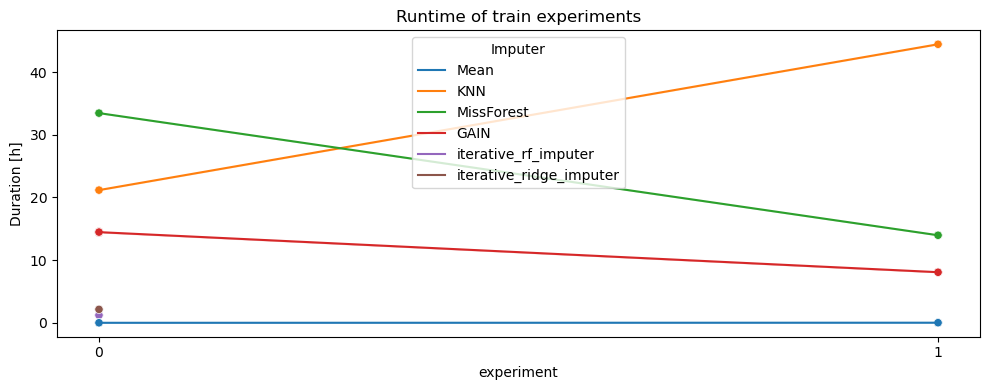

In [21]:
# overall runtime
temp = df_config[df_config["Imputer"].isin(["mean_imputer", "knn_imputer", "missforest_imputer", "gain_imputer"])]
temp = df_config.copy()

plt.rcParams["figure.figsize"] = (10, 4)
sns.lineplot(temp, x="experiment", y="duration_h", hue="Imputer")
sns.scatterplot(temp, x="experiment", y="duration_h", hue="Imputer", legend=False)
# plt.yscale("log")  
plt.ylabel("Duration [h]")
plt.xticks(ticks=temp.experiment.unique())
plt.title("Runtime of train experiments")
plt.tight_layout()
plt.savefig(output_path + "train_experiment_runtime.png")
plt.show()

In [31]:
df_config.groupby(["Imputer"]).mean().sort_values("overall_runtime")

,timestamp,overall_runtime,tuning_iterations,experiment,duration_h
Imputer,,,,,
Mean,1.679484e+09,46.230426,50.0,0.5,0.012842
iterative_rf_imputer,1.684494e+09,4424.612346,10.0,0.0,1.229059
iterative_ridge_imputer,1.684512e+09,7727.047735,50.0,0.0,2.146402
GAIN,1.681030e+09,40580.854258,5.5,0.5,11.272460
MissForest,1.679757e+09,85359.037387,50.0,0.5,23.710844
KNN,1.679571e+09,118085.500197,50.0,0.5,32.801528


In [22]:
c = df_tuning_results.rename(columns={"imputer": "Imputer"})
c.replace(map_imputer_label, inplace=True)

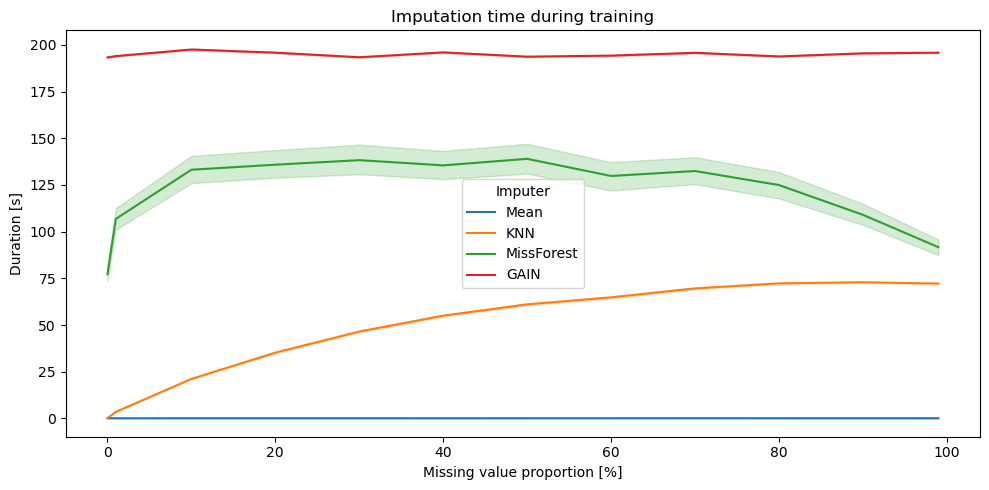

In [23]:
temp = c[c["Imputer"].isin(map_imputer_label.values())]
# temp = c.copy()

plt.rcParams["figure.figsize"] = (10, 5)
sns.lineplot(temp, x="missing_value_proportion", y="time", hue="Imputer")
plt.xlabel("Missing value proportion [%]")
plt.ylabel("Duration [s]")
plt.title("Imputation time during training")
plt.tight_layout()
plt.savefig(output_path + "train_imputation_runtime_overExps.png")
plt.show()

In [26]:
temp.groupby("Imputer").mean()

,iteration,missing_value_proportion,time,rmse
Imputer,,,,
GAIN,2.8125,45.833687,194.908079,0.157915
KNN,24.5000,45.833687,47.871278,0.021272
Mean,24.5000,45.833687,0.090764,0.074687
MissForest,24.5000,45.833687,121.136129,0.148028


# How does the error look like for dropping from all columns (complete tuple)?

In [ ]:
output_path = f"output/imputation/{timestamp}/"
config_path = f"{output_path}config.csv"

In [ ]:
# load hyperparameter tuning result files and config file (original experiment is exp1)
df_config = pd.read_csv(config_path)
config_entry = df_config[(df_config["timestamp"] == int(timestamp)) & 
                (df_config["host"] == str(host)) & 
                (df_config["imputer_name"] == str(imputer_name))]

tuning_filenames = config_entry["tuning_filenames"].values[0].replace("[", "").replace("]", "").replace("'", "").split(", ")
filename0 = [x for x in tuning_filenames if "imputer0.csv" in x]
filename1 = [x for x in tuning_filenames if "imputer1.csv" in x]
filename2 = [x for x in tuning_filenames if "imputer2.csv" in x]

if filename0:
    filename0 = filename0[0]
    df0 = pd.read_csv(filename0)
    print(f"Number of iterations experiment 0: {len(df0['iteration'].value_counts())}")
    
if filename1:
    filename1 = filename1[0]
    df1 = pd.read_csv(filename1)
    print(f"Number of iterations experiment 1: {len(df1['iteration'].value_counts())}")
    
if filename2:
    filename2 = filename2[0]
    df2 = pd.read_csv(filename2)
    print(f"Number of iterations experiment 2: {len(df2['iteration'].value_counts())}")

In [ ]:
def handle_multiple_same_errors(df):
    a = df.groupby(["missing_value_proportion", "imputer", "predicting"]).count().reset_index()
    a_entries = list(a[a['rmse'] > 1].index)
    for a_idx in a_entries:
        idx_valid = False
        while not idx_valid: 
            print(f"Which entry do you want to keep? Please indicate by typing the index")
            temp = df[(df["missing_value_proportion"] == a["missing_value_proportion"][a_idx]) & (df["imputer"] == a["imputer"][a_idx]) & (df["predicting"] == a["predicting"][a_idx])]
            print(temp)
            typed_idx = int(input())
            if typed_idx in list(temp.index):
                idx_valid = True
                df = df.drop([x for x in list(temp.index) if x != typed_idx])
            else: 
                print("Invalid index. Please try again.")
        
            print()
    
    return df.reset_index()
                

In [ ]:
def average_over_iterations(df):
    df["hyperparameters"] = df["hyperparameters"].astype(str)
    df = df.groupby(["missing_value_proportion", "predicting", "hyperparameters", "imputer"]).mean().reset_index()
    df = df.drop("iteration", axis=1)
    return df

In [ ]:
df1_result

In [ ]:
# preprocessing
if filename1:
    # average over iterations
    df1_it = average_over_iterations(df1)

    # find minimum RMSE for every combination of missing_value_proportion, imputer, predicting
    df1_min = df1_it.groupby(["missing_value_proportion", "imputer", "predicting"])["rmse"].min().reset_index()

    # get index of minimum RMSE and get corresponding hyperparameters from original df (before min-grouping)
    df1_result = pd.DataFrame(columns=df1_it.columns)
    for i in range(len(df1_min)):
        temp = df1_it[df1_it["rmse"] == df1_min["rmse"].iloc[i]]
        df1_result = pd.concat([df1_result, temp])
        
    # check if a minimum RMSE is present more than once
    # @todo: introduce a threshold for this
    if (df1_result.groupby(["missing_value_proportion", "imputer", "predicting"]).count().reset_index()["rmse"] > 1).any():
        print("Please check manually!! There are multiple hyperparameter combinations with the same error.")
        df1_result = handle_multiple_same_errors(df1_result)   
    else: 
        print("All good. No error is double, i.e. hyperparmeter selection is unambiguous.")
        
    print("Hyperparameter combinations and their frequency:")
    print(df1_result["hyperparameters"].value_counts())
    
    # add each hyperparameter as a separate colum to df
    df1_result["hyperparameters"] = df1_result["hyperparameters"].apply(lambda x: x.replace(": nan,", ": np.nan,"))  # replace nan by np.nan (string)
    dicts1 = df1_result["hyperparameters"].apply(eval)  # turn string to dict
    df1_dicts = pd.DataFrame.from_records(dicts1.values, index=dicts1.index)  
    df1_result[df1_dicts.columns] = df1_dicts  # add each hyperparameter as a separate columns to df
    
    # map hyperparameters to category for plotting purposes
    df1_result["hyperparameters"] = df1_result.hyperparameters.astype('category')
    df1_result['hyperparameters_c'] = df1_result.hyperparameters.cat.codes

In [ ]:
# preprocessing
if filename0:
    # average over iterations
    df0_it = average_over_iterations(df0)
    
    # find minimum RMSE for every combination of missing_value_proportion, imputer, predicting
    df0_min = df0_it.groupby(["missing_value_proportion", "imputer", "predicting"])["rmse"].min().reset_index()

    # get index of minimum RMSE and get corresponding hyperparameters from original df (before min-grouping)
    df0_result = pd.DataFrame(columns=df0_it.columns)
    for i in range(len(df0_min)):
        temp = df0_it[df0_it["rmse"] == df0_min["rmse"].iloc[i]]
        df0_result = pd.concat([df0_result, temp])
    
    # replace nan by np.nan (string)
    df0_result["hyperparameters"] = df0_result["hyperparameters"].apply(lambda x: x.replace(": nan,", ": np.nan,"))  
        
if filename2:
    # average over iterations
    df2_it = average_over_iterations(df2)

In [ ]:
list(df1_result["predicting"].unique())

In [ ]:
# plotting
if filename1:
    # sns.violinplot(data=df1_result, x="predicting", y="rmse")#, hue="hyperparameters")

    plt.rcParams["figure.figsize"] = (10, 5)
    fig, ax = plt.subplots()
    sc = ax.scatter(df1_result["predicting"], df1_result["rmse"], c=df1_result["hyperparameters_c"], s=2*df1_result["missing_value_proportion"].astype(float), alpha=0.3)
    #sc = ax.scatter(df1_result["hyperparameters"], df1_result["rmse"], c=df1_result["missing_value_proportion"])
    
    handles, labels = sc.legend_elements(prop="colors")
    cats = [int(''.join(i for i in x if i.isdigit())) for x in labels]
    new_labels = [df1_result[df1_result["hyperparameters_c"] == cats[i]].iloc[0]["hyperparameters"] for i in cats] 
    legend2 = ax.legend(handles, new_labels, loc="upper left", title="Combinations", bbox_to_anchor=(1.05, 1))

    plt.title("Hyperparameter combinations")
    plt.ylabel("RMSE")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"{output_path}{timestamp}_hyperparameter_tuning_result_{imputer_name}.png")
    plt.show()
    
    plt.rcParams["figure.figsize"] = (10, 5)
    sns.scatterplot(data=df1_result, x="missing_value_proportion", y="rmse", hue="hyperparameters", s=100)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

In [ ]:
fig = px.scatter(df1_result, x="missing_value_proportion", y="rmse", color="hyperparameters", symbol="predicting", 
                labels={"missing_value_proportion": "Missing value proportion [%]", "rmse": "RMSE"}, width=1800)

fig.show()
print(f"{output_path}{timestamp}_hyperparameter_tuning_result_plt2_{imputer_name}.png")

In [ ]:
if filename1: 
    # save results (best hyperparameter combination for each combination of missing-value_proportion, imputer, predicting)
    result_file1 = f"{output_path}{timestamp}_hyperparameter_tuning_result_{imputer_name}1.csv"
    df1_result.to_csv(result_file1, index=False)

    # add result file path to config (if evaluation files already exists, extend the list)
    if "evaluate_tuning_filenames" in df_config.columns:
        temp_entry = df_config.loc[config_entry.index.values[0], "evaluate_tuning_filenames"]
        if isinstance(temp_entry, str):
            temp_entry = temp_entry.replace("]", "").replace("[", "").replace("'", "").split(", ")
            temp_entry.append(result_file1)
            temp_entry = list(set(temp_entry))
            df_config.loc[config_entry.index.values[0], "evaluate_tuning_filenames"] = str(temp_entry)
        else:
            df_config.loc[config_entry.index.values[0], "evaluate_tuning_filenames"].append([result_file1])
    else:
        df_config.loc[config_entry.index.values[0], "evaluate_tuning_filenames"] = [result_file1]
    
    # write to csv
    df_config.to_csv(config_path, index=False)

In [ ]:
df_config.loc[config_entry.index.values[0], "evaluate_tuning_filenames"]

# How much does the imputer learn through tuple where at least one value is missing?

In [ ]:
if filename1 and filename2:
    parameters = list(filter(lambda x: x.startswith('P_'), list(df1.columns)))

    temp = df1_it.copy()
    temp["rmse"] = temp["rmse"].astype(float)
    temp["time"] = temp["time"].astype(float)
    temp["missing_value_proportion"] = temp["missing_value_proportion"].astype(float)
    temp["predicting_cat"] = temp['predicting'].astype("str")#.cat.codes.values
    t = temp[["missing_value_proportion", "predicting_cat", "rmse"]].groupby(["missing_value_proportion", "predicting_cat"]).mean().reset_index()

    temp1 = df2_it.copy()
    temp1.columns = [c + "1" for c in temp1.columns]
    temp1["rmse1"] = temp1["rmse1"].astype(float)
    temp1["time1"] = temp1["time1"].astype(float)
    temp1["missing_value_proportion1"] = temp1["missing_value_proportion1"].astype(float)
    temp1["predicting_cat1"] = temp1['predicting1'].astype("str")#.cat.codes.values
    t1 = temp1[["missing_value_proportion1", "predicting_cat1", "rmse1"]].groupby(["missing_value_proportion1", "predicting_cat1"]).mean().reset_index()

    tt = pd.concat([t, t1], axis=1)

    custom_palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
    a = sns.lineplot(x="missing_value_proportion", y="rmse", data=tt, hue="predicting_cat", 
                     #palette=custom_palette
                     )
    b = sns.scatterplot(data=tt, x="missing_value_proportion1", y="rmse1", hue="predicting_cat1", legend=False
                        #palette=custom_palette
                       )

    a.legend(title='Predicted parameter', bbox_to_anchor=(1, 1), frameon=False)

    plt.xlabel("Missing values [%]")
    plt.ylabel("RMSE")
    plt.title("Difference between removing value from predicted column (-) vs removing complete tuple (.)")
    plt.savefig(f"{output_path}{timestamp}_hyperparameter_tuning_result_{imputer_name}_reomveTuple.png")
    plt.show()

In [ ]:
if filename1 and filename2: 
    parameters = list(filter(lambda x: x.startswith('P_'), list(df1_it.columns)))
    
    # make sure that the correct values are matched
    a = df1_it.merge(df2_it, on=["missing_value_proportion", "predicting", "hyperparameters", "imputer"], suffixes=(None, "_all"))
    
    sns.lineplot(a, x="missing_value_proportion", y="rmse", errorbar=None)#, linewidth=10)
    sns.lineplot(a, x="missing_value_proportion", y="rmse_all", linestyle='--', errorbar=None)
    # plt.legend(labels=["Remove from one param", "Remove from all params"])
    plt.xlabel("Missing values [%]")
    plt.ylabel("RMSE")
    plt.title("Difference between removing value from predicted column (blue) vs removing from all columns (orange)")
    plt.savefig(f"{output_path}{timestamp}_hyperparameter_tuning_result_{imputer_name}_removeFromAll.png")
    plt.show()

# Optimal hyperparameters when removing globally from all columns

In [ ]:
if filename0:
    plt.rcParams["figure.figsize"] = (20, 3)
    sns.violinplot(data=df0, x="iteration", y="rmse")#, hue="missing_value_proportion")#, legend=False)
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.savefig(f"{output_path}{timestamp}_hyperparameter_tuning_result_{imputer_name}_removeGlobally_iterations.png")
    plt.show()

In [ ]:
if filename0:
    plt.rcParams["figure.figsize"] = (5, 3)
    sc = sns.scatterplot(data=df0_result, x="missing_value_proportion", y="rmse", hue="hyperparameters")
    plt.legend(bbox_to_anchor=(0, 1.35), loc='upper left', borderaxespad=0)
    plt.ylabel("RMSE")
    plt.xlabel("Missing value proportion [%]")
    plt.tight_layout()
    plt.savefig(f"{output_path}{timestamp}_hyperparameter_tuning_result_{imputer_name}_removeGlobally.png")
    plt.show()

In [ ]:
if filename0: 
    # save results (best hyperparameter combination for each combination of missing-value_proportion, imputer, predicting)
    result_file0 = f"{output_path}{timestamp}_hyperparameter_tuning_result_{imputer_name}0.csv"
    df0_result.to_csv(result_file0, index=False)

    # add result file path to config (if evaluation files already exists, extend the list)
    if "evaluate_tuning_filenames" in df_config.columns:
        temp_entry = df_config.loc[config_entry.index.values[0], "evaluate_tuning_filenames"]
        if isinstance(temp_entry, str):
            temp_entry = temp_entry.replace("]", "").replace("[", "").replace("'", "").split(", ")
            temp_entry.append(result_file0)
            temp_entry = list(set(temp_entry))
            df_config.loc[config_entry.index.values[0], "evaluate_tuning_filenames"] = str(temp_entry)
        else:
            df_config.loc[config_entry.index.values[0], "evaluate_tuning_filenames"].append([result_file0])
    else:
        df_config.loc[config_entry.index.values[0], "evaluate_tuning_filenames"] = [result_file0]
    
    # write to csv
    df_config.to_csv(config_path, index=False)

In [ ]:
df_config["evaluate_tuning_filenames"].values

In [ ]:
# # plot all exp0 in a violin plot
# df_mean0 = average_over_iterations(pd.read_csv(f"output/imputation/1678788887/1678788887_hyperparameter_tuning_mean_imputer0.csv"))
# df_knn0 = average_over_iterations(pd.read_csv(f"output/imputation/1678460471/1678460471_hyperparameter_tuning_knn_imputer0.csv"))
# df_miss0 = average_over_iterations(pd.read_csv(f"output/imputation/1678789001/1678789001_hyperparameter_tuning_missforest_imputer0.csv"))

# df_all = pd.concat([df_mean0, df_knn0, df_miss0],axis=0)

# plt.rcParams["figure.figsize"] = (5, 3)
# sns.violinplot(data=df_all, x="imputer", y="rmse")#, legend=False)
# plt.xlabel("Iteration")
# plt.ylabel("RMSE")
# plt.tight_layout()
# plt.savefig(f"output/imputation/hyperparameter_tuning_result_exp0.png")
# plt.show()